In [1]:
import os
import warnings
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util as cutil
import cmocean
import dask
from dask.distributed import Client, LocalCluster, Worker, progress
from dask.diagnostics import ProgressBar
pbar = ProgressBar()
pbar.register()
#from dask_jobqueue import SLURMCluster
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xesmf as xe
from load_SAIdata import Cases
%matplotlib inline

In [2]:
ds = xr.open_dataset('../data/SST.nc')
with xr.open_dataset('../data/landmask.f02_t12.nc') as dset:
    ds['mask'] = dset.KMT
ds['dpm'] = ('month', [31,28,31,30,31,30,31,31,30,31,30,31])

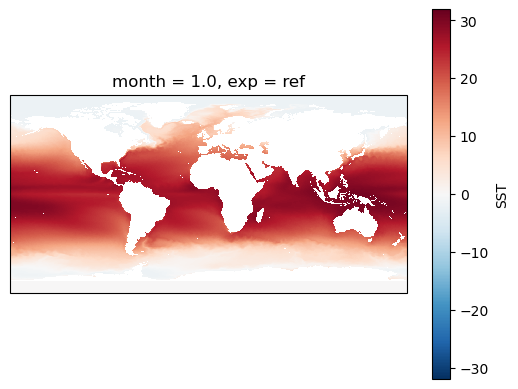

In [3]:
ax=plt.axes(projection=ccrs.PlateCarree())
ds.SST.sel(exp='ref', month=1).where(ds.mask<0.1).plot(ax=ax, transform=ccrs.PlateCarree())


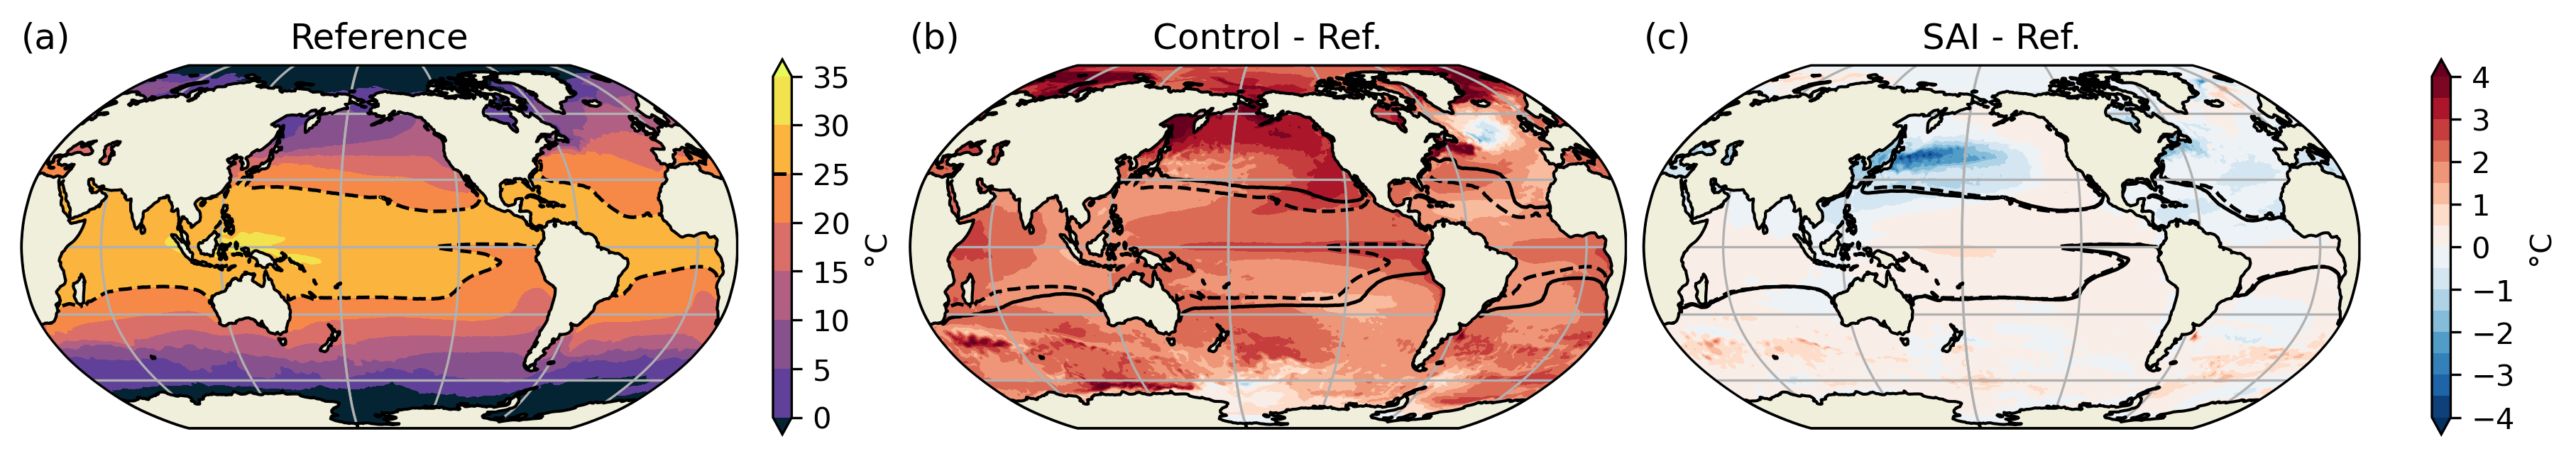

In [4]:
lats, lons = xr.broadcast(ds.lat, ds.lon)
kwargs = dict(transform=ccrs.PlateCarree(), transform_first=True)

# for data, title in zip((SST.mean('month', keep_attrs=True), SST.sel(month=10), SST.sel(month=4)), ['annual','october','april']):
data = ds.SST.weighted(ds.dpm).mean('month')

fig,axs = plt.subplots(1,3, dpi=300, figsize=(12,4), layout='constrained', subplot_kw={'projection':ccrs.Robinson(central_longitude=200)})

ax=axs[0]
pcm = ax.contourf(lons, lats, data.sel(exp='ref'), levels=np.arange(0,36,5), extend='both', vmin=-10, cmap='cmo.thermal', **kwargs)
pcc = ax.contour(lons, lats, data.sel(exp='ref'), levels=[25], colors='k', linewidths=1.2, linestyles='--', **kwargs)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pcm.set_rasterized(True)
    
cb = fig.colorbar(pcm, ax=axs[0], shrink=0.45, orientation='vertical')
cb.ax.axhline(25, lw=1.2, ls='--', c='k')
cb.ax.set_ylabel('°C')
ax.set_title('Reference')
ax.set_title('(a)', loc='left')

ax = axs[1]
ddata = data.sel(exp='cnt') - data.sel(exp='ref')
pcm = ax.contourf(lons, lats, ddata, levels=np.arange(-4,4.1,0.5), extend='both', cmap='RdBu_r', **kwargs)
pcc1 = ax.contour(lons, lats, data.sel(exp='ref'), levels=[25], colors='k', linewidths=1.2, linestyles='--', **kwargs)
pcc2 = ax.contour(lons, lats, data.sel(exp='cnt'), levels=[25], colors='k', linewidths=1.2, linestyles='-', **kwargs)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pcm.set_rasterized(True)
ax.set_title('Control - Ref.')
ax.set_title('(b)', loc='left')

ax = axs[2]
ddata = data.sel(exp='sai') - data.sel(exp='ref')
pcm = ax.contourf(lons, lats, ddata, levels=np.arange(-4,4.1,0.5), extend='both', cmap='RdBu_r', **kwargs)
pcc1 = ax.contour(lons, lats, data.sel(exp='ref'), levels=[25], colors='k', linewidths=1.2, linestyles='--', **kwargs)
pcc2 = ax.contour(lons, lats, data.sel(exp='sai'), levels=[25], colors='k', linewidths=1.2, linestyles='-', **kwargs)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pcm.set_rasterized(True)
ax.set_title('SAI - Ref.')
ax.set_title('(c)', loc='left')

cb = fig.colorbar(pcm, ax=axs[1:], shrink=0.45, orientation='vertical')
cb.ax.set_ylabel('°C')

for ax in axs.flatten():
    ax.gridlines()
    ax.add_feature(cfeature.LAND, zorder=2, edgecolor='black')

#fig.suptitle('annual mean SST', y=0.9)
fig.savefig('../figures/SST.annualmean.pdf', dpi=300, bbox_inches='tight', transparent=True)


/scratch-local/55013/ipykernel_2169993/3024692775.py:12: UserWarning: Rasterization of '<cartopy.mpl.contour.GeoContourSet object at 0x14524fd0bb00>' will be ignored
  pcm.set_rasterized(True)


cnt-ref 330.6593933105469


/scratch-local/55013/ipykernel_2169993/3024692775.py:24: UserWarning: Rasterization of '<cartopy.mpl.contour.GeoContourSet object at 0x145250d4a090>' will be ignored
  pcm.set_rasterized(True)


sai-ref -148.5986785888672 79.80299377441406


/scratch-local/55013/ipykernel_2169993/3024692775.py:35: UserWarning: Rasterization of '<cartopy.mpl.contour.GeoContourSet object at 0x14524fca6870>' will be ignored
  pcm.set_rasterized(True)


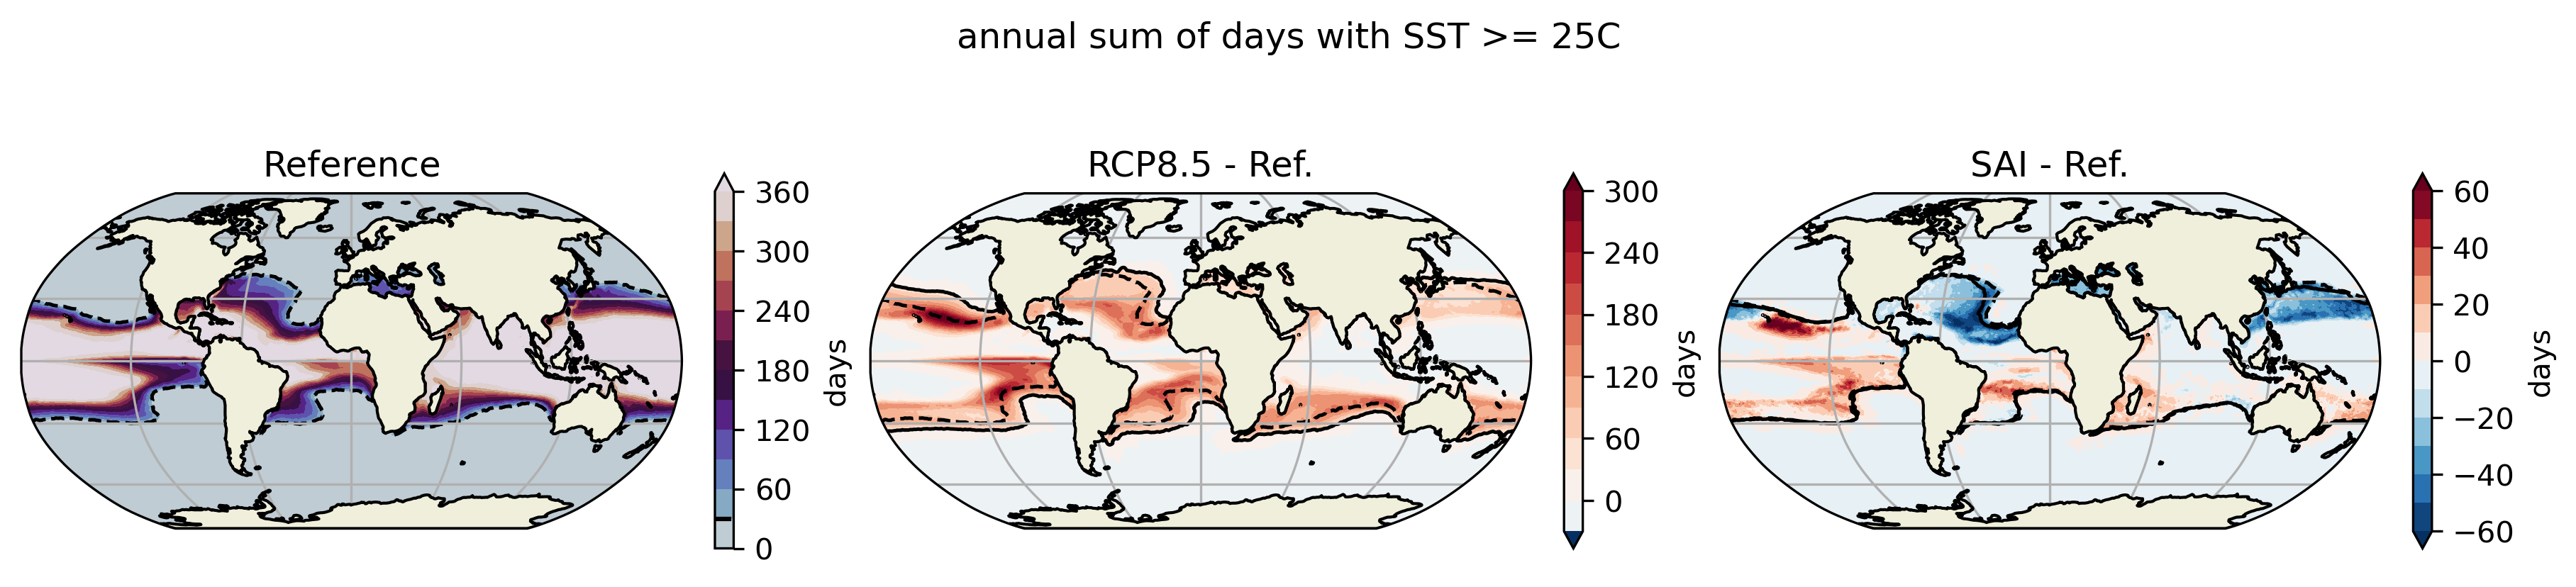

In [5]:
lats, lons = xr.broadcast(ds.lat, ds.lon)
kwargs = dict(transform=ccrs.PlateCarree(), transform_first=True)

# for data, title in zip((SST.mean('month', keep_attrs=True), SST.sel(month=10), SST.sel(month=4)), ['annual','october','april']):
data = ds.SSTdays.sum('month')

fig,axs = plt.subplots(1,3, dpi=300, figsize=(12,4), layout='constrained', subplot_kw={'projection':ccrs.Robinson()})

ax=axs[0]
ax.set_title('Reference')
pcm = ax.contourf(lons, lats, data.sel(exp='ref'), levels=np.arange(0,366,30), extend='max', vmin=-10, cmap='twilight', **kwargs)
pcm.set_rasterized(True)
ax.contour(lons, lats, data.sel(exp='ref'), levels=[30], colors='k', linewidths=1.2, linestyles='--', **kwargs)
cb = fig.colorbar(pcm, ax=axs[0], shrink=0.45, orientation='vertical')
cb.ax.set_ylabel('days')
cb.ax.axhline(30, c='k', ls='--')


ax = axs[1]
ax.set_title('RCP8.5 - Ref.')
ddata = data.sel(exp='cnt') - data.sel(exp='ref')
print('cnt-ref',ddata.max().item())
pcm = ax.contourf(lons, lats, ddata, levels=np.arange(-30,301,30), vmin=-300, extend='both', cmap='RdBu_r', **kwargs)
pcm.set_rasterized(True)
ax.contour(lons, lats, data.sel(exp='ref'), levels=[30], colors='k', linewidths=1.2, linestyles='--', **kwargs)
ax.contour(lons, lats, data.sel(exp='cnt'), levels=[30], colors='k', linewidths=1.2, linestyles='-', **kwargs)
cb = fig.colorbar(pcm, ax=axs[1], shrink=0.45, orientation='vertical')
cb.ax.set_ylabel('days')

ax = axs[2]
ax.set_title('SAI - Ref.')
ddata = data.sel(exp='sai') - data.sel(exp='ref')
print('sai-ref',ddata.min().item(),ddata.max().item())
pcm = ax.contourf(lons, lats, ddata, levels=np.arange(-60,60.1,10), extend='both', cmap='RdBu_r', **kwargs)
pcm.set_rasterized(True)
ax.contour(lons, lats, data.sel(exp='ref'), levels=[30], colors='k', linewidths=1.2, linestyles='--', **kwargs)
ax.contour(lons, lats, data.sel(exp='sai'), levels=[30], colors='k', linewidths=1.2, linestyles='-', **kwargs)
cb = fig.colorbar(pcm, ax=axs[2], shrink=0.45, orientation='vertical')
cb.ax.set_ylabel('days')

for ax in axs.flatten():
    ax.gridlines()
    ax.add_feature(cfeature.LAND, zorder=2, edgecolor='black')

fig.suptitle('annual sum of days with SST >= 25C', y=0.9)
fig.savefig('../figures/SST.highdays.annualsum.pdf', bbox_inches='tight', transparent=True)


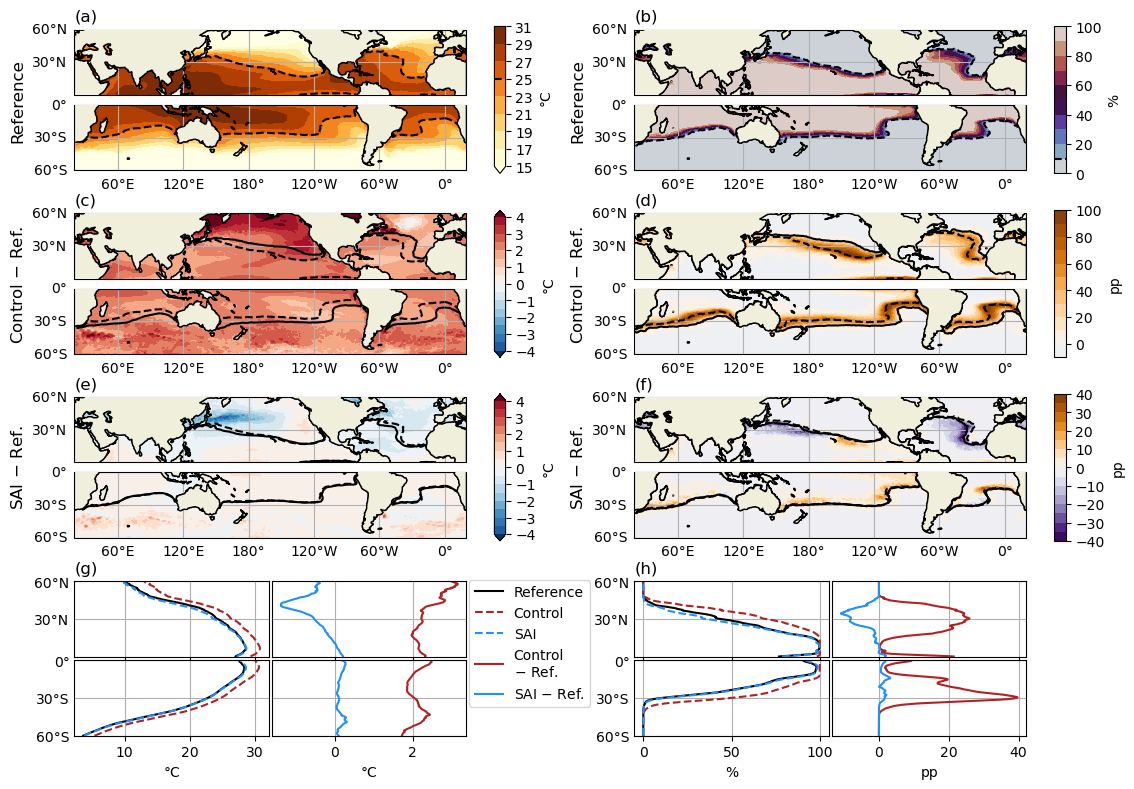

In [5]:
SST_NH = ds.SST.sel(month=[6,7,8,9,10], lat=slice(0,60)).weighted(ds.dpm).mean('month')
SST_SH = ds.SST.sel(month=[1,2,3,4,5], lat=slice(-60,0)).weighted(ds.dpm).mean('month')
days_NH = ds.SSTdays.sel(month=[6,7,8,9,10], lat=slice(0,60)).sum('month') / ds.dpm.sel(month=[6,7,8,9,10]).sum('month') * 100
days_SH = ds.SSTdays.sel(month=[1,2,3,4,5], lat=slice(-60,0)).sum('month') / ds.dpm.sel(month=[1,2,3,4,5]).sum('month') * 100

cfdata = {
    'a': [SST_NH.sel(exp='ref'), SST_SH.sel(exp='ref')],
    'b': [days_NH.sel(exp='ref'), days_SH.sel(exp='ref')],
    'c': [SST_NH.sel(exp='cnt')-SST_NH.sel(exp='ref'),
          SST_SH.sel(exp='cnt')-SST_SH.sel(exp='ref')],
    'd': [days_NH.sel(exp='cnt')-days_NH.sel(exp='ref'),
          days_SH.sel(exp='cnt')-days_SH.sel(exp='ref')],
    'e': [SST_NH.sel(exp='sai')-SST_NH.sel(exp='ref'),
          SST_SH.sel(exp='sai')-SST_SH.sel(exp='ref')],
    'f': [days_NH.sel(exp='sai')-days_NH.sel(exp='ref'),
          days_SH.sel(exp='sai')-days_SH.sel(exp='ref')],
}

cfkwargs = {
    'a': dict(transform=ccrs.PlateCarree(), levels=np.linspace(15,31,9), extend='min',     cmap='YlOrBr'),
    'b': dict(transform=ccrs.PlateCarree(), levels=np.linspace(0,100,11), extend='neither', cmap='twilight'),
    'c': dict(transform=ccrs.PlateCarree(), levels=np.linspace(-4,4,17),  extend='both',    cmap='RdBu_r', vmin=-4.5, vmax=4.5),
    'd': dict(transform=ccrs.PlateCarree(), levels=np.linspace(-10,100,12),extend='neither', cmap='PuOr_r', vmin=-100, vmax=100),
    'e': dict(transform=ccrs.PlateCarree(), levels=np.linspace(-4,4,17),  extend='both', cmap='RdBu_r', vmin=-4.5, vmax=4.5),
    'f': dict(transform=ccrs.PlateCarree(), levels=np.linspace(-40,40,17),extend='neither', cmap='PuOr_r', vmin=-40, vmax=40),
}

cbkwargs = {'a': dict(label='°C'), 'b': dict(label='%'), 'c': dict(label='°C'),
    'd': dict(label='pp'), 'e': dict(label='°C'),'f': dict(label='pp')}

supy = {'a': 'Reference', 'b': 'Reference', 'c': 'Control $-$ Ref.',
        'd': 'Control $-$ Ref.', 'e': 'SAI $-$ Ref.', 'f': 'SAI $-$ Ref.'}

fig = plt.figure(figsize=(14*0.8, 0.6125*14*0.9))
subfigs = fig.subfigures(2, 1, hspace=0.0, height_ratios=[3, 1.2])
mapfigs = subfigs[0].subfigures(3,2,hspace=0, wspace=0)
zmfigs = subfigs[1].subfigures(1,2,wspace=0)

for i,mfig, in zip('abcdef', mapfigs.flatten()):
    axt, axb = mfig.subplots(2,1, sharex=True, subplot_kw={'projection':ccrs.PlateCarree(central_longitude=200)})
    cft = axt.contourf(cfdata[i][0].lon, cfdata[i][0].lat, cfdata[i][0], **cfkwargs[i])
    cfb = axb.contourf(cfdata[i][1].lon, cfdata[i][1].lat, cfdata[i][1], **cfkwargs[i])
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        cft.set_rasterized(True)
        cfb.set_rasterized(True)
    for ax in (axt, axb):
        ax.coastlines()
        ax.add_feature(cfeature.LAND, zorder=3, edgecolor='k')
        ax.set_title('')
        ax.set_xlabel('')
        ax.set_ylabel('')
    axt.gridlines(ylocs=[0, 30, 60], draw_labels=['left'])
    axb.gridlines(ylocs=[0,-30,-60], draw_labels=['left','bottom'])
    axt.set_extent((20,380,0,60.0001), crs=ccrs.PlateCarree())
    axb.set_extent((20,380,-60.001,0.001), crs=ccrs.PlateCarree())
    mfig.subplots_adjust(left=0.125, right=0.825, top=0.9, bottom=0.1, hspace=0.05)
    cbtax = mfig.add_axes((0.875,0.1,0.02,0.8))
    mfig.colorbar(cft, cax=cbtax, **cbkwargs[i])
    axt.set_title(f'({i})', loc='left')
    mfig.supylabel(supy[i], x=0.01)

for v,var in enumerate([(SST_NH,SST_SH),(days_NH,days_SH)]):
    clevels = [[25], [10]][v]
    for m,(mfig,exp) in enumerate(zip(mapfigs[:,v],['ref','cnt','sai'])):
        if m == 0:
            mfig.axes[2].axhline(clevels, ls='--', c='k')
        for a,ax in enumerate(mfig.axes[:2]):
            cr = ax.contour(var[a].lon, var[a].lat, var[a].sel(exp='ref'), transform=ccrs.PlateCarree(), levels=clevels, linestyles=['--'], zorder=2, colors='k')
            if m >= 1:
                ce = ax.contour(var[a].lon, var[a].lat, var[a].sel(exp=exp), transform=ccrs.PlateCarree(), levels=clevels, linestyles=['-'], zorder=2, colors='k')


for z,zfig in enumerate(zmfigs.flatten()):
    axs = zfig.subplots(2,2, sharey='row', sharex='col')
    zfig.subplots_adjust(left=0.125, right=0.825, top=0.9, bottom=0.2, wspace=0.05/3)
    for ax in axs[0,:]:
        ax.set_ylim([0,60])
        ax.yaxis.set_tick_params(length=0)
    for ax in axs[1,:]:
        ax.set_ylim([-60,0])
        ax.yaxis.set_tick_params(length=0)
    axs[0,0].set_yticks([30,60], labels=['30°N','60°N'])
    axs[1,0].set_yticks([-60,-30,0], labels=['60°S','30°S','0°'])
    
for z,zfig in enumerate(zmfigs.flatten()):
    zfig.axes[0].set_title(f'({"gh"[z]})', loc='left')
    data_NH = [SST_NH.where(ds.mask<0.1), days_NH.where(ds.mask<0.1)][z]
    data_SH = [SST_SH.where(ds.mask<0.1), days_SH.where(ds.mask<0.1)][z]
    data_NH.sel(exp='ref').mean('lon').plot(ax=zfig.axes[0], y='lat', c='k', label='Reference')
    data_NH.sel(exp='cnt').mean('lon').plot(ax=zfig.axes[0], y='lat', c='firebrick', ls='--', label='Control')
    data_NH.sel(exp='sai').mean('lon').plot(ax=zfig.axes[0], y='lat', c='dodgerblue', ls='--', label='SAI')
    
    (data_NH.sel(exp='cnt').mean('lon')
     -data_NH.sel(exp='ref').mean('lon')).plot(ax=zfig.axes[1], y='lat', c='firebrick', label='Control\n$-$ Ref.')
    (data_NH.sel(exp='sai').mean('lon')
     -data_NH.sel(exp='ref').mean('lon')).plot(ax=zfig.axes[1], y='lat', c='dodgerblue', label='SAI $-$ Ref.')
    
    data_SH.sel(exp='ref').mean('lon').plot(ax=zfig.axes[2], y='lat', c='k', label='Reference')
    data_SH.sel(exp='cnt').mean('lon').plot(ax=zfig.axes[2], y='lat', c='firebrick', ls='--', label='Control')
    data_SH.sel(exp='sai').mean('lon').plot(ax=zfig.axes[2], y='lat', c='dodgerblue', ls='--', label='SAI')
    
    (data_SH.sel(exp='cnt').mean('lon')
     -data_SH.sel(exp='ref').mean('lon')).plot(ax=zfig.axes[3], y='lat', c='firebrick', label='Control\n$-$ Ref.')
    (data_SH.sel(exp='sai').mean('lon')
     -data_SH.sel(exp='ref').mean('lon')).plot(ax=zfig.axes[3], y='lat', c='dodgerblue', label='SAI $-$ Ref.')

han1, lab1 = zmfigs[0].axes[0].get_legend_handles_labels()
han2, lab2 = zmfigs[0].axes[1].get_legend_handles_labels()
zmfigs[0].legend(han1+han2, lab1+lab2, loc=(0.83,0.33))



for zfig in zmfigs:
    # zfig.set_edgecolor('k')
    # zfig.set_linewidth(.01)
    for ax in zfig.axes:
        ax.yaxis.set_tick_params(length=0)
        ax.set_title('')
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.grid()

zmfigs[0].axes[2].set_xlabel('°C')
zmfigs[0].axes[3].set_xlabel('°C')
zmfigs[1].axes[2].set_xlabel('%')
zmfigs[1].axes[3].set_xlabel('pp')

fig.savefig('../figures/SST.TCseason.pdf', dpi=300, transparent=True, bbox_inches='tight')

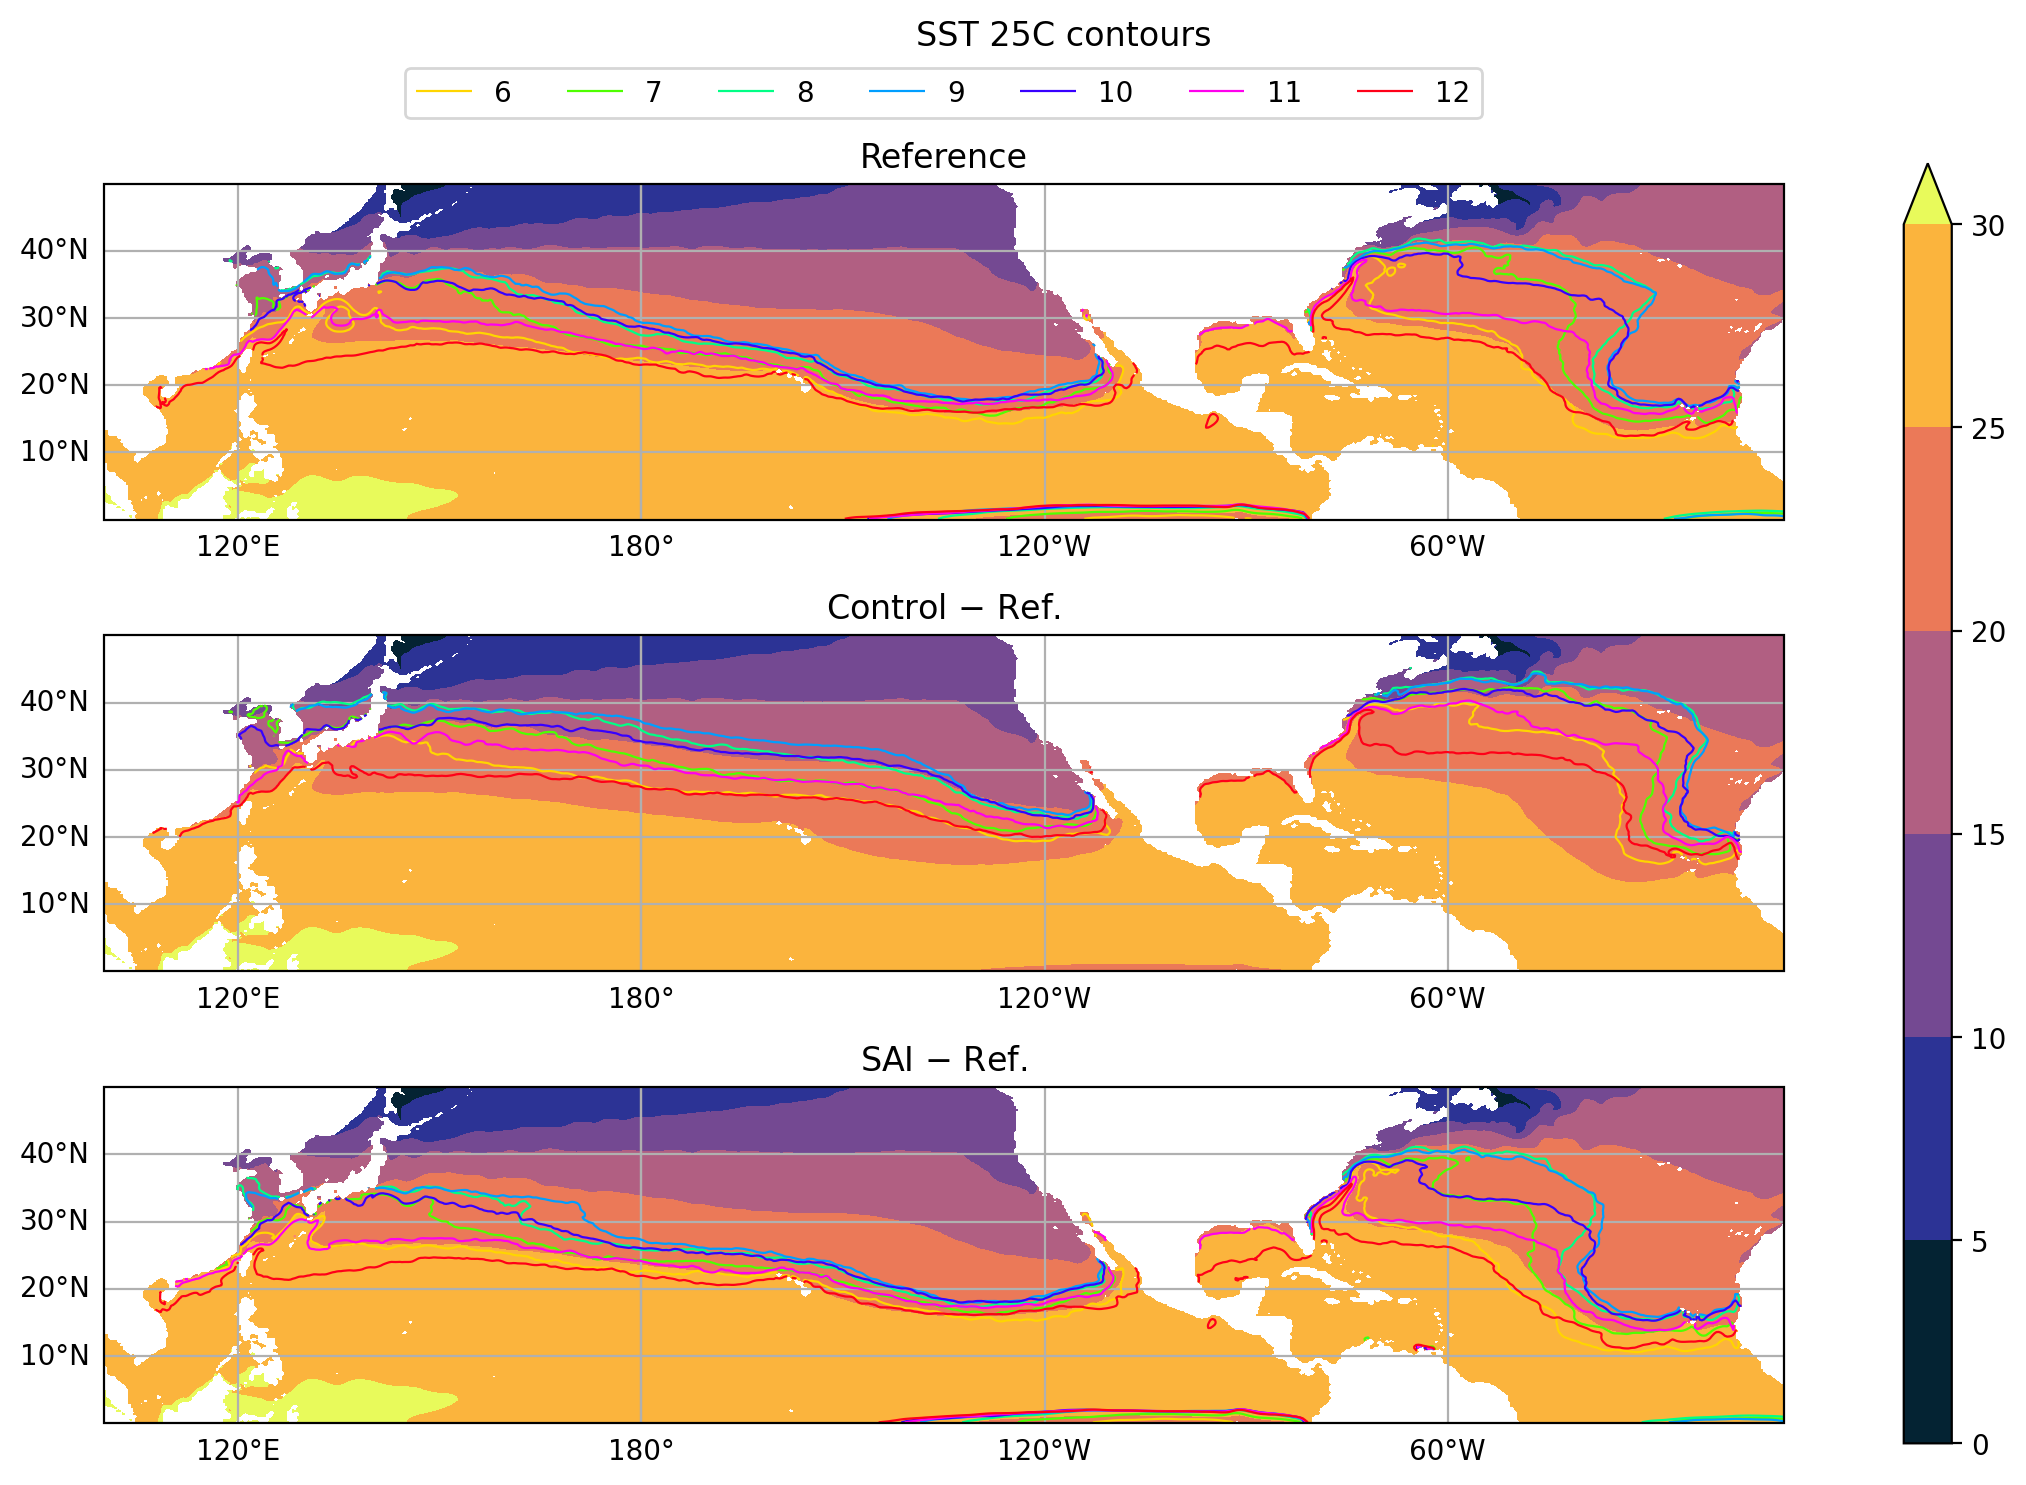

In [63]:
fig,axs = plt.subplots(3,1, figsize=(12,8), sharex=True, sharey=True, dpi=200,subplot_kw={'projection':ccrs.PlateCarree(central_longitude=200)})

months = [3,4,5,6,7,8,9,10,11,12,1,2]
months = [6,7,8,9,10,11,12]
legend_elems = []
for ax,exp,tit in zip(axs, ['ref','cnt','sai'],['Reference','Control $-$ Ref.','SAI $-$ Ref.']):
    cf = ds.SST.sel(exp='ref', lat=slice(0,50)).weighted(ds.dpm).mean('month').where(ds.mask<0.1).plot.contourf(ax=ax, transform=ccrs.PlateCarree(), cmap='cmo.thermal', add_colorbar=False, levels=range(0,31,5))
    ax.gridlines(draw_labels=['left','bottom'])
    for m,month in enumerate(months):
        cs = ds.SST.sel(exp=exp,month=month,lat=slice(0,50)).where(ds.mask<0.1).plot.contour(ax=ax, transform=ccrs.PlateCarree(), levels=[25], linewidths=[0.8], colors=[plt.get_cmap('hsv')((m+1)/len(months))])
        legend_elems.append(cs.legend_elements()[0][0])
    ax.set_extent((100,350,0,50), crs=ccrs.PlateCarree())
    ax.set_title(tit)

plt.subplots_adjust(0.1,0.1,0.8,0.9)
cbax = fig.add_axes((0.85,0.1,0.02,0.8))
fig.colorbar(cf, cax=cbax, shrink=0.5)

fig.legend(legend_elems, months, ncol=12, loc=(0.2,0.92))
fig.suptitle('SST 25C contours',y=0.99, ha='center')
fig.savefig('../figures/SST.25C.monmean.NH.pdf', bbox_inches='tight', transparent=True)

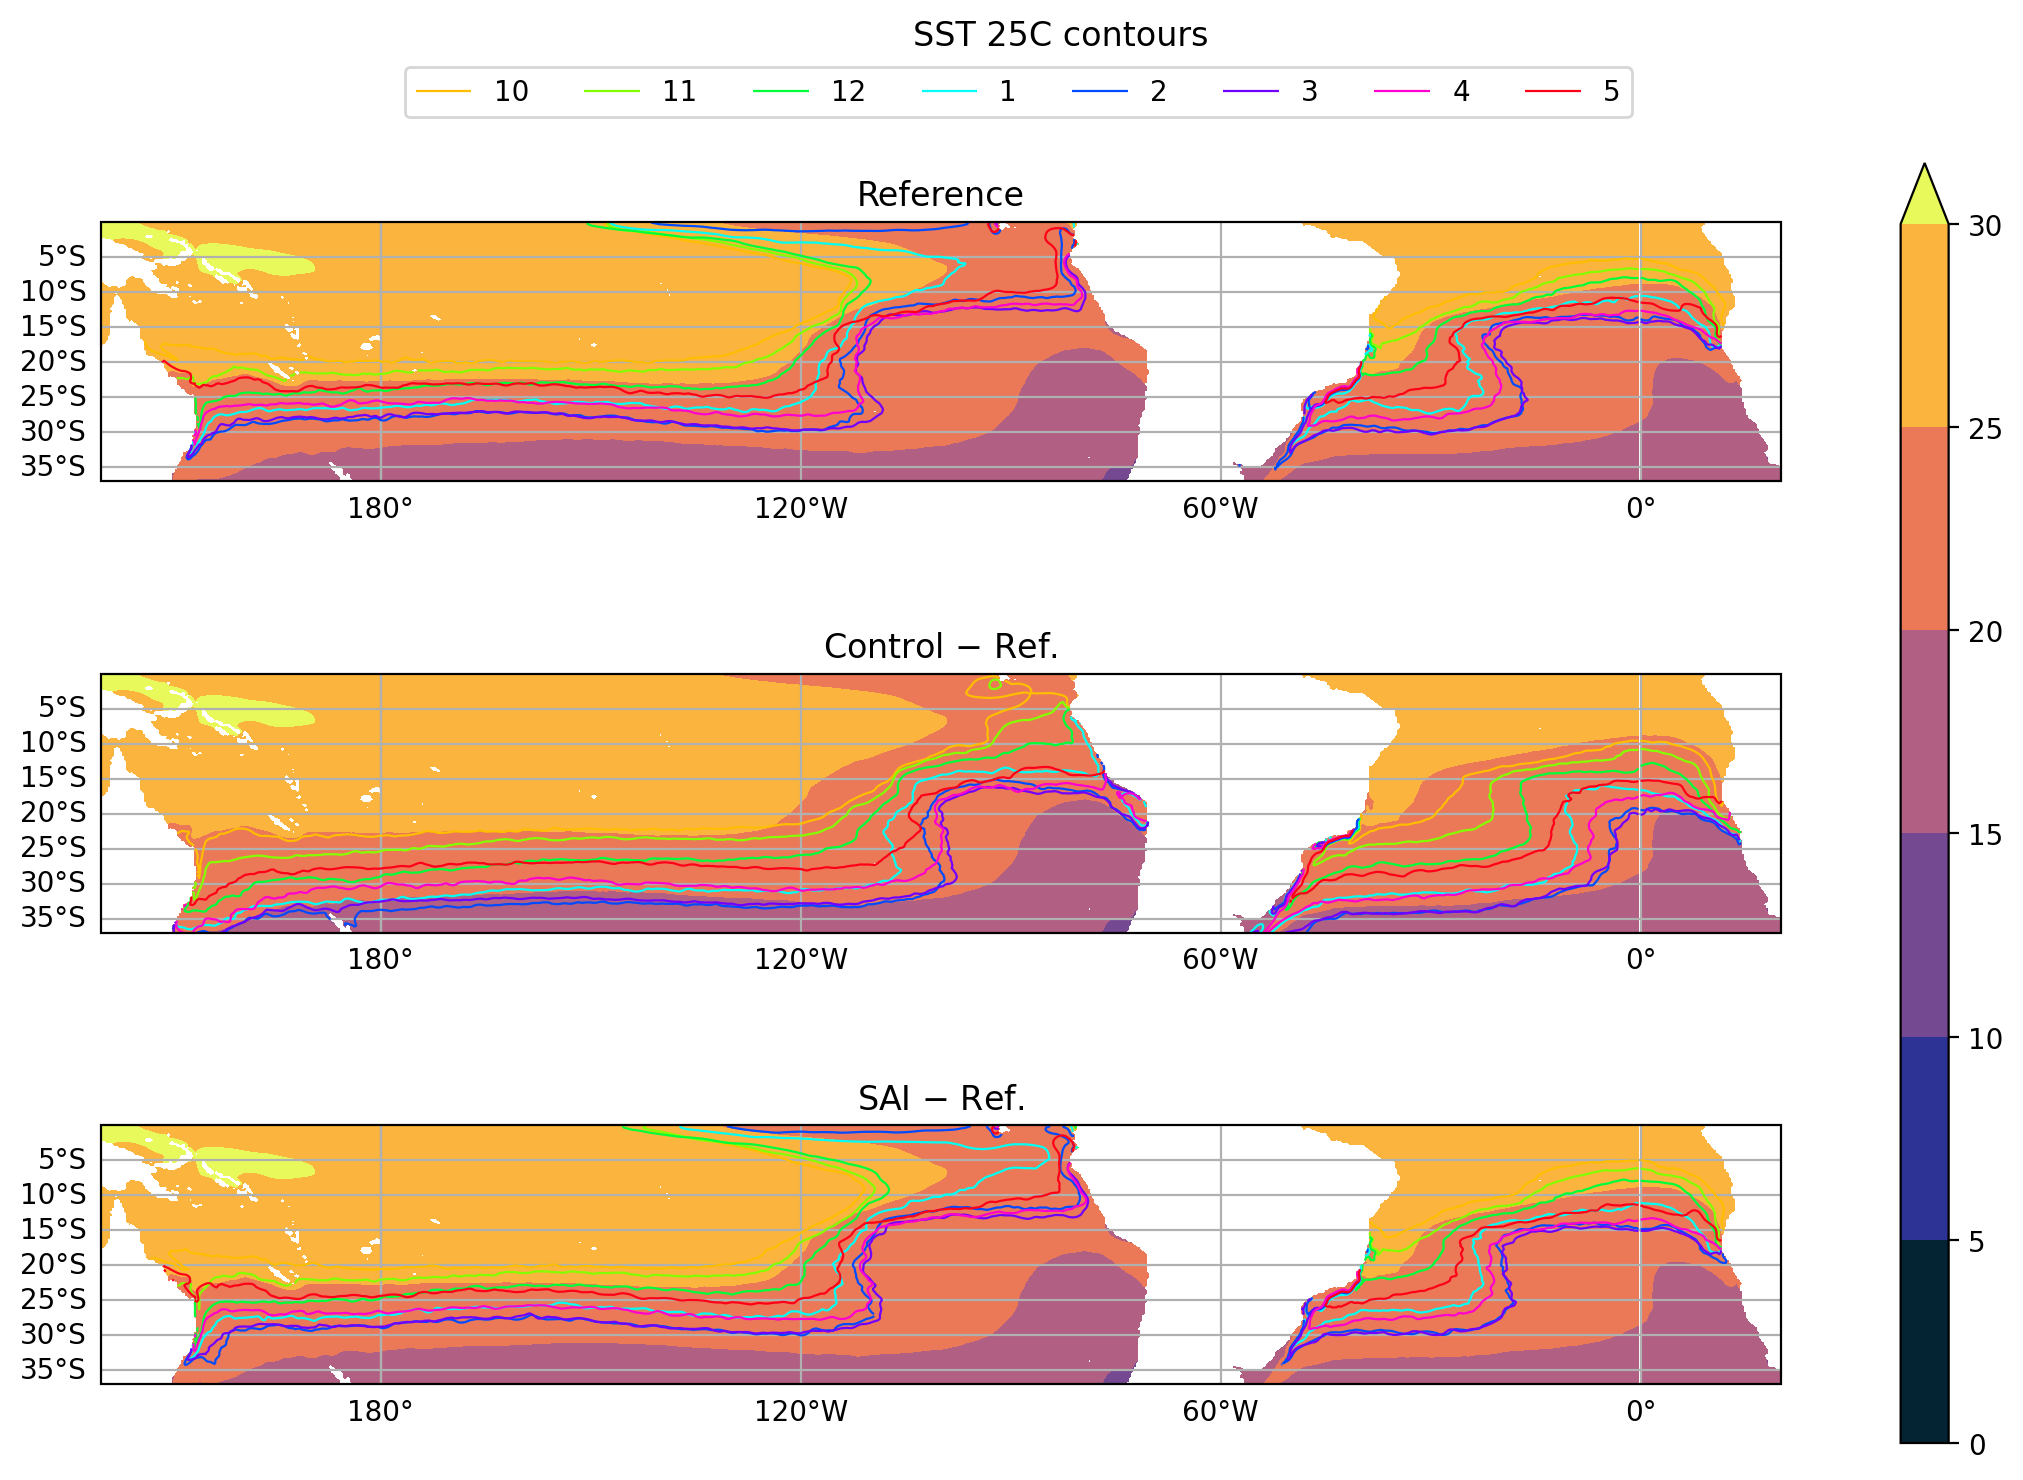

In [77]:
fig,axs = plt.subplots(3,1, figsize=(12,8), sharex=True, sharey=True, dpi=200,subplot_kw={'projection':ccrs.PlateCarree(central_longitude=300)})

months = [3,4,5,6,7,8,9,10,11,12,1,2]
months = [10,11,12,1,2,3,4,5]
legend_elems = []
for ax,exp,tit in zip(axs, ['ref','cnt','sai'],['Reference','Control $-$ Ref.','SAI $-$ Ref.']):
    cf = ds.SST.sel(exp='ref', lat=slice(-40,0)).weighted(ds.dpm).mean('month').where(ds.mask<0.1).plot.contourf(ax=ax, transform=ccrs.PlateCarree(), cmap='cmo.thermal', add_colorbar=False, levels=range(0,31,5))
    ax.gridlines(draw_labels=['left','bottom'])
    for m,month in enumerate(months):
        cs = ds.SST.sel(exp=exp,month=month,lat=slice(-40,0)).where(ds.mask<0.1).plot.contour(ax=ax, transform=ccrs.PlateCarree(), levels=[25], linewidths=[0.8], colors=[plt.get_cmap('hsv')((m+1)/len(months))])
        legend_elems.append(cs.legend_elements()[0][0])
    ax.set_extent((140,380,-37,0), crs=ccrs.PlateCarree())
    ax.set_title(tit)

plt.subplots_adjust(0.1,0.1,0.8,0.9)
cbax = fig.add_axes((0.85,0.1,0.02,0.8))
fig.colorbar(cf, cax=cbax, shrink=0.5)

fig.legend(legend_elems, months, ncol=12, loc=(0.2,0.92))
fig.suptitle('SST 25C contours',y=0.99, ha='center')
fig.savefig('../figures/SST.25C.monmean.SH.pdf', bbox_inches='tight', transparent=True)

In [2]:
# Final code for TCs-under-SAI/analysis/jobs/SST/regridder.py

""" Regrid 0.1deg POP data (tripolar grid) to the 0.25 deg CAM grid"""

import glob
import os
import numpy as np
import xarray as xr
import xesmf as xe
from load_SAIdata import Cases

# parameters for generating remap weights
SRC_GRID_FILE = './data/SST.hres.sai.6.nc' # 6th member has a 'nice' lon field (no -1 inland)
DST_GRID_FILE = ('/projects/0/nwo2021025/archive/hres_b.e10.B2000_CAM5.f02_t12.started_2092-12.001/'
                 + 'atm/hist/hres_b.e10.B2000_CAM5.f02_t12.started_2092-12.001.cam2.h0.2092-12.nc')
REMAP_METHOD  = 'conservative' # passed to xe.Regridder
WEIGHTS_FILE  = f'./data/remapweights_(tx0.1v2)_(f02_t12)_{REMAP_METHOD}.nc'

# append tag to output filename
DST_TAG = 'f02_t12'


def _compute_corners(ULAT, ULONG):
    """Compute grid corners. (copied from pop-tools/grid.py)"""

    nlat, nlon = ULAT.shape
    corner_lat = np.empty((nlat, nlon, 4), dtype=float)
    corner_lon = np.empty((nlat, nlon, 4), dtype=float)

    # NE corner
    corner_lat[:, :, 0] = ULAT
    corner_lon[:, :, 0] = ULONG

    # NW corner (copy from NE corner of column to the left, assume zonal periodic bc)
    corner_lat[:, :, 1] = np.roll(corner_lat[:, :, 0], 1, axis=1)
    corner_lon[:, :, 1] = np.roll(corner_lon[:, :, 0], 1, axis=1)

    # SW corner (copy from NW corner of row below, bottom row is extrapolated from 2 rows above)
    corner_lat[1:nlat, :, 2] = corner_lat[0 : nlat - 1, :, 1]
    corner_lon[1:nlat, :, 2] = corner_lon[0 : nlat - 1, :, 1]
    corner_lat[0, :, 2] = corner_lat[1, :, 2] - (corner_lat[2, :, 2] - corner_lat[1, :, 2])
    corner_lon[0, :, 2] = corner_lon[1, :, 2] - (corner_lon[2, :, 2] - corner_lon[1, :, 2])

    # SE corner (copy from NE corner of row below, bottom row is extrapolated from 2 rows above)
    corner_lat[1:nlat, :, 3] = corner_lat[0 : nlat - 1, :, 0]
    corner_lon[1:nlat, :, 3] = corner_lon[0 : nlat - 1, :, 0]
    corner_lat[0, :, 3] = corner_lat[1, :, 3] - (corner_lat[2, :, 3] - corner_lat[1, :, 3])
    corner_lon[0, :, 3] = corner_lon[1, :, 3] - (corner_lon[2, :, 3] - corner_lon[1, :, 3])

    return corner_lat, corner_lon


def gen_corner_calc(ds, cell_corner_lat_name='ULAT', cell_corner_lon_name='ULONG'):
    """
    Generates corner information and creates single dataset with output
    (adapted from https://ncar.github.io/esds/posts/2021/regrid-observations-pop-grid/)
    """

    cell_corner_lat = ds[cell_corner_lat_name]
    cell_corner_lon = ds[cell_corner_lon_name]
    ds = ds.drop_vars([cell_corner_lat_name, cell_corner_lon_name])
    
    # Use the function in pop-tools to get the grid corner information
    corn_lat, corn_lon = _compute_corners(cell_corner_lat, cell_corner_lon)

    # Make sure this returns four corner points
    assert corn_lon.shape[-1] == 4

    lon_shape, lat_shape = corn_lon[:, :, 0].shape
    out_shape = (lon_shape + 1, lat_shape + 1)

    # Generate numpy arrays to store destination lats/lons
    out_lons = np.zeros(out_shape)
    out_lats = np.zeros(out_shape)

    # Assign the northeast corner information
    out_lons[1:, 1:] = corn_lon[:, :, 0]
    out_lats[1:, 1:] = corn_lat[:, :, 0]

    # Assign the northwest corner information
    out_lons[1:, :-1] = corn_lon[:, :, 1]
    out_lats[1:, :-1] = corn_lat[:, :, 1]

    # Assign the southwest corner information
    out_lons[:-1, :-1] = corn_lon[:, :, 2]
    out_lats[:-1, :-1] = corn_lat[:, :, 2]

    # Assign the southeast corner information
    out_lons[:-1, 1:] = corn_lon[:, :, 3]
    out_lats[:-1, 1:] = corn_lat[:, :, 3]

    ds['lon_b'] = (('nlat_b', 'nlon_b'), out_lons)
    ds['lat_b'] = (('nlat_b', 'nlon_b'), out_lats)   

    return ds


def conform_dataset(ds):
    """add cell corners and rename to lat/lon for xesmf regridder""" 
    ds = gen_corner_calc(ds)
    ds = ds.rename({'TLAT':'lat', 'TLONG':'lon'})
    return ds


def gen_remap_weights():
    """generate remap weights"""
    dst = xr.open_dataset(DST_GRID_FILE)[['lat','lon']] # CAM file
    src = xr.open_dataset(SRC_GRID_FILE) # POP file
    src = conform_dataset(src)
    regrid = xe.Regridder(src, dst, method=REMAP_METHOD)
    regrid.to_netcdf(WEIGHTS_FILE)
    return


def main():
    if not os.path.exists(WEIGHTS_FILE):
        print('generating weights')
        gen_remap_weights()
    else:
        print(f'using {WEIGHTS_FILE}')
    dst_grid = xr.open_dataset(DST_GRID_FILE)[['lat','lon']] # CAM file

    files = sorted(glob.glob('./data/SST.hres.???.?.nc'))
    for file in files:
        ds = xr.open_dataset(file)
        ds = conform_dataset(ds)
        regrid = xe.Regridder(ds, dst_grid, method=REMAP_METHOD, weights=WEIGHTS_FILE, 
                              reuse_weights=True, extrap_method='inverse_dist')
        regridded = regrid(ds)
        outfile = file.rstrip('.nc') + f'.{DST_TAG}.nc'
        print(f'writing {outfile}')
        regridded.to_netcdf(outfile)
    return


# if __name__ == '__main__':
#     main()

Reading combined kerchunk reference file /home/jasperdj/kerchunk/hres_b.e10.B2000_CAM5.f02_t12.started_2092-12.001.pop.h.nday1.2092-12-01_2097-12-01.json
[########################################] | 100% Completed | 508.87 ms
[########################################] | 100% Completed | 309.81 ms


In [56]:
# Final code for TCs-under-SAI/analysis/jobs/SST/SST.py

import os
import datetime
import flox 
import xarray as xr
from load_SAIdata import Cases
import physics


tslices = {  # analysis periods, inclusive
    'ref': slice('2003','2007'), 
    'cnt': slice('2093','2097'), 
    'sai': slice('2093','2097')
}

def array_job_id_to_case(i):
    """generate case tag for SLURM array job id"""
    return [case for case in Cases.cases if 'hres.' in case][int(i)]


def center_timestamps(ds):
    """center timestamps in their interval given by time_bnds"""
    # only compute the centered time from time_bnds on the first step,
    # as computing it on all steps is quite slow
    tbounds = ds[ds.time.bounds]
    if 'nbnd' in tbounds.dims:
        bnd_dim = 'nbnd'
    elif 'd2' in tbounds.dims:
        bnd_dim = 'd2'
    else:
        raise NotImplementedError(f'Bound dimension unknown. {tbounds.dims=}')
    citime = tbounds[0].mean(bnd_dim).compute() # centered initial time
    dsec = (citime - ds.time[0]).dt.total_seconds().item()
    dtshift = datetime.timedelta(seconds=dsec)
    ds['time'] = ds.time + dtshift
    return ds


def get_timestep(ds):
    """Get timestep in days"""
    dt = (ds.time[1] - ds.time[0]).dt.total_seconds().item()
    return dt/86400


def open_ds_daily_ocn(exp, ens, center_time=True, **kwargs):
    """open daily POP dataset for one ensemble member"""
    ds = (
        Cases(f'hres.{exp}.{ens}')
        .select('ocn','h.nday1')
        .open_mfdataset(**kwargs)
        #.assign_coords(exp=exp, ens=int(ens))
    )

    if center_time:
        ds = center_timestamps(ds)

    return ds


def main():
    arrjobid = os.environ['SLURM_ARRAY_TASK_ID']
    tag = array_job_id_to_case(arrjobid)
    print(f'{tag=}')
    _,exp,ens = tag.split('.')
    ds = open_ds_daily_ocn(exp, ens, decode_timedelta=True)
    ds = ds.sel(time=tslices[exp])

    # monthly mean SST
    SSTmonmean = ds.SST.resample(time='1MS').mean().groupby('time.month').mean()
    
    # monthly mean days with SST >= 25C
    dt = get_timestep(ds)
    SSTdays = (ds.SST >= 25) * dt
    SSTdays = SSTdays.resample(time='1MS').sum().groupby('time.month').mean()
    SSTdays = SSTdays.astype('float32').assign_attrs({
        'long_name': 'number of days having SST >= 25C'})

    os.makedirs('./data', exist_ok=True)
    outname = f'./data/SST.{tag}.nc'
    out = xr.Dataset({'SST': SSTmonmean, 'SSTdays': SSTdays})
    print(f'writing to {outname}')
    out.to_netcdf(outname)
    return


# if __name__ == '__main__':
#     main()

In [ ]:
# !mv ../jobs/SST/data/SST.nc ../data/

## Computations

In [55]:
import os
import datetime
import flox 
import xarray as xr
from load_SAIdata import Cases
import physics


tslices = {  # analysis periods, inclusive
    'ref': slice('2003','2007'), 
    'cnt': slice('2093','2097'), 
    'sai': slice('2093','2097')
}


def array_job_id_to_case(i):
    """generate case tag for SLURM array job id"""
    return [case for case in Cases.cases if 'hres.' in case][int(i)]


def center_timestamps(ds):
    """center timestamps in their interval given by time_bnds"""
    # only compute the centered time from time_bnds on the first step,
    # as computing it on all steps is quite slow
    tbounds = ds[ds.time.bounds]
    if 'nbnd' in tbounds.dims:
        bnd_dim = 'nbnd'
    elif 'd2' in tbounds.dims:
        bnd_dim = 'd2'
    else:
        raise NotImplementedError(f'Bound dimension unknown. {tbounds.dims=}')
    citime = tbounds[0].mean(bnd_dim).compute() # centered initial time
    dsec = (citime - ds.time[0]).dt.total_seconds().item()
    dtshift = datetime.timedelta(seconds=dsec)
    ds['time'] = ds.time + dtshift
    return ds


def get_timestep(ds):
    """Get timestep in days"""
    dt = (ds.time[1] - ds.time[0]).dt.total_seconds().item()
    return dt/86400


def open_ds_daily_ocn(exp, ens, center_time=True, **kwargs):
    """open daily POP dataset for one ensemble member"""
    ds = (
        Cases(f'hres.{exp}.{ens}')
        .select('ocn','h.nday1')
        .open_mfdataset(**kwargs)
        .assign_coords(exp=exp, ens=int(ens))
    )

    if center_time:
        ds = center_timestamps(ds)

    return ds


def main():
    arrjobid = os.environ['SLURM_ARRAY_TASK_ID']
    tag = array_job_id_to_case(arrjobid)
    print(f'{tag=}')
    _,exp,ens = tag.split('.')
    ds = open_ds_daily_ocn(exp, ens, decode_timedelta=True)
    ds = ds.sel(time=tslices[exp])

    # monthly mean SST
    SSTmonmean = ds.SST.resample(time='1MS').mean().groupby('time.month').mean()
    
    # monthly mean days with SST >= 25C
    dt = get_timestep(ds)
    SSTdays = (ds.SST >= 25) * dt
    SSTdays = SSTdays.resample(time='1MS').sum().groupby('time.month').mean()
    SSTdays = SSTdays.astype('float32').assign_attrs({
        'long_name': 'number of days having SST >= 25C'})

    outname = f'../../data/VWS.{tag}.nc'
    out = xr.Dataset({'SST': SSTmonmean, 'SSTdays': SSTdays})
    print(f'writing to {outname}')
    out.to_netcdf(outname)
    return


# if __name__ == '__main__':
#     main()


In [58]:
ds = open_ds_daily_ocn('ref',1, decode_timedelta=True)

Reading combined kerchunk reference file /home/jasperdj/kerchunk/b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_2002-12.001.pop.h.nday1.2002-12-01_2012-12-01.json
[########################################] | 100% Completed | 102.06 ms
[########################################] | 100% Completed | 102.11 ms


In [59]:
get_timestep(ds)

1.0

In [2]:
# %%time

# open_kwargs = dict(decode_times=True, decode_timedelta=True) #, chunks={'nlat':24})
# exps = [case for case in Cases.cases if 'hres' in case]
# ds = {exp: Cases(exp).select('ocn','h.nday1').open_mfdataset(**open_kwargs) for exp in exps}

In [2]:
%%time

open_kwargs = dict(decode_times=True, decode_timedelta=True) #, chunks={'nlat':24})
exps = [case for case in Cases.cases if 'hres' in case]
files = {exp: Cases(exp).select('ocn','h.nday1').files for exp in exps}

CPU times: user 632 ms, sys: 189 ms, total: 821 ms
Wall time: 6.7 s


In [59]:
ds0 = xr.open_dataset(files['hres.sai.1'][0], decode_timedelta=True)
ds0.close()
for exp in files:
    with xr.open_dataset(files[exp][0], decode_timedelta=True) as ds:
        is_equal = (np.abs(ds.TLONG - ds0.TLONG) < 1e-12).all().item()
        print(exp, is_equal)
ds0.close()

hres.ref.1 False
hres.ref.2 False
hres.ref.3 False
hres.ref.4 False
hres.ref.5 False
hres.ref.6 False
hres.cnt.1 False
hres.cnt.2 False
hres.cnt.3 False
hres.cnt.4 False
hres.cnt.5 False
hres.cnt.6 False
hres.sai.1 True
hres.sai.2 True
hres.sai.3 True
hres.sai.4 True
hres.sai.5 True
hres.sai.6 False


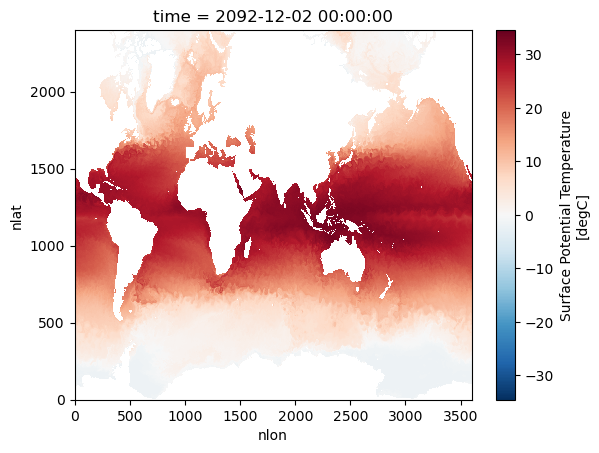

In [66]:
ds.SST.isel(time=0).plot(x='nlon', y='nlat')

In [69]:
ds = xr.open_dataset('./pop.test.nc')

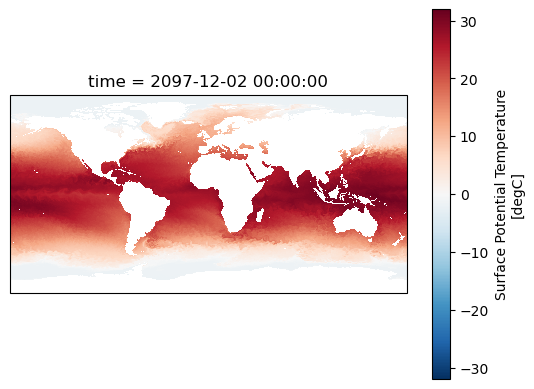

In [74]:
ax = plt.axes(projection=ccrs.PlateCarree())
ds.SST.isel(time=0).plot(ax=ax,transform=ccrs.PlateCarree())

In [ ]:
ax = plt.axes(projection=ccrs.PlateCarree())
ds0.SST.isel(time=0).plot(x='nlon', y='nlat', transform=ccrs.PlateCarree())

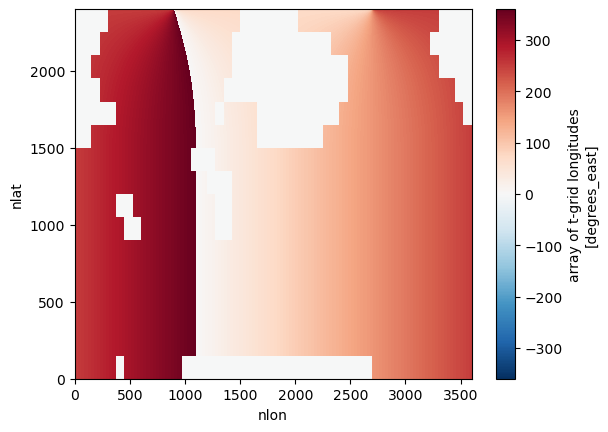

In [64]:
ds0.TLONG.plot()

/scratch-local/55013/ipykernel_2597001/3023551807.py:1: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset(files['hres.cnt.6'][0])


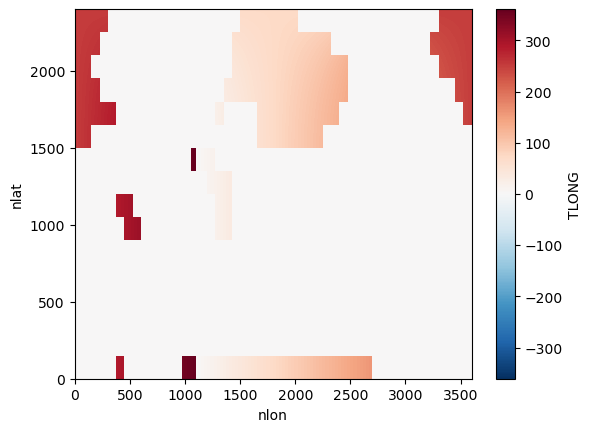

In [61]:
ds = xr.open_dataset(files['hres.cnt.6'][0])
(ds.TLONG - ds0.TLONG).plot()

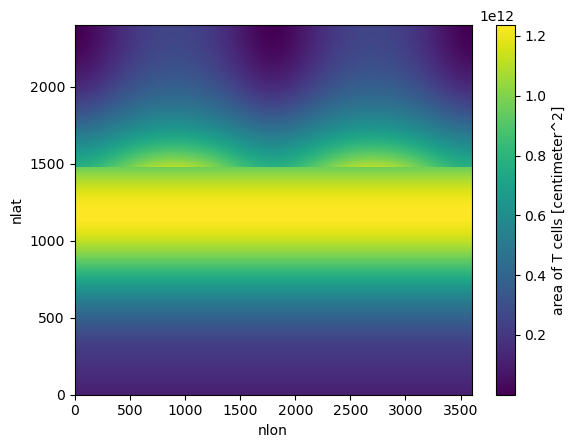

In [47]:
ds.TAREA.plot()

Write a list of files corresponding to each ensemble member

In [2]:
hres_tags = (tag for tag in Cases.cases if 'hres' in tag)

for tag in hres_tags:
    flist = Cases(tag).select('ocn','h.nday1').files[:]
    with open(f'{os.environ['TMPDIR']}/files.{tag}','w') as f:
        print('writing', f.name)
        f.write(' '.join(flist))

writing /scratch-local/jasperdj.18370101/files.hres.ref.1
writing /scratch-local/jasperdj.18370101/files.hres.ref.2
writing /scratch-local/jasperdj.18370101/files.hres.ref.3
writing /scratch-local/jasperdj.18370101/files.hres.ref.4
writing /scratch-local/jasperdj.18370101/files.hres.ref.5
writing /scratch-local/jasperdj.18370101/files.hres.ref.6
writing /scratch-local/jasperdj.18370101/files.hres.cnt.1
writing /scratch-local/jasperdj.18370101/files.hres.cnt.2
writing /scratch-local/jasperdj.18370101/files.hres.cnt.3
writing /scratch-local/jasperdj.18370101/files.hres.cnt.4
writing /scratch-local/jasperdj.18370101/files.hres.cnt.5
writing /scratch-local/jasperdj.18370101/files.hres.cnt.6
writing /scratch-local/jasperdj.18370101/files.hres.sai.1
writing /scratch-local/jasperdj.18370101/files.hres.sai.2
writing /scratch-local/jasperdj.18370101/files.hres.sai.3
writing /scratch-local/jasperdj.18370101/files.hres.sai.4
writing /scratch-local/jasperdj.18370101/files.hres.sai.5
writing /scrat

In the cell below, the multi-year monthly mean SST is computed. Timestamps are first centered at the (daily) intervals to obtain the correct dates.

In [4]:
%%bash
module purge
module load 2025
module load CDO/2.5.2-gompi-2025a

for filelist in $TMPDIR/files.*;
do
    tag=${filelist#$TMPDIR/files.}   # simulation tag [ hres.ref.1, etc ... ]
    exp=$(cut -d'.' -f2 <<< "$tag")  # experiment [ ref, cnt, sai ]
    if [[ $exp == "ref" ]];
    then
        years=2003/2007
    else
        years=2093/2097
    fi
    files=($(cat $filelist))
    outfile=$TMPDIR/outfile.$tag.nc
    echo "$(date +[%H:%M:%S]) writing to $outfile"

    cdo select,name=SST,timestep=1 ${files[0]} $outfile # dummy
    
    # # write SST as monthly mean timeseries
    cdo -O -f nc4 --chunkspec t=12,x=1800,y=1200 -ymonmean -selyear,$years \
    -mergetime [ -shifttime,-12hours -selname,SST : ${files[@]} ] $outfile
done

[08:20:56] writing to /scratch-local/jasperdj.18276587/outfile.hres.cnt.1.nc
[08:23:42] writing to /scratch-local/jasperdj.18276587/outfile.hres.cnt.2.nc
[08:26:33] writing to /scratch-local/jasperdj.18276587/outfile.hres.cnt.3.nc
[08:29:24] writing to /scratch-local/jasperdj.18276587/outfile.hres.cnt.4.nc
[08:32:12] writing to /scratch-local/jasperdj.18276587/outfile.hres.cnt.5.nc
[08:35:01] writing to /scratch-local/jasperdj.18276587/outfile.hres.cnt.6.nc
[08:37:56] writing to /scratch-local/jasperdj.18276587/outfile.hres.ref.1.nc
[08:43:18] writing to /scratch-local/jasperdj.18276587/outfile.hres.ref.2.nc
[08:46:07] writing to /scratch-local/jasperdj.18276587/outfile.hres.ref.3.nc
[08:48:58] writing to /scratch-local/jasperdj.18276587/outfile.hres.ref.4.nc
[08:51:49] writing to /scratch-local/jasperdj.18276587/outfile.hres.ref.5.nc
[08:54:42] writing to /scratch-local/jasperdj.18276587/outfile.hres.ref.6.nc
[08:57:34] writing to /scratch-local/jasperdj.18276587/outfile.hres.sai.1.nc

In [5]:
%%bash
module purge
module load 2025
module load CDO/2.5.2-gompi-2025a

cdo ensmean $TMPDIR/outfile.hres.ref.?.nc ../data/SST.monmean.ref.1-6.nc
cdo ensmean $TMPDIR/outfile.hres.cnt.?.nc ../data/SST.monmean.cnt.1-6.nc
cdo ensmean $TMPDIR/outfile.hres.sai.?.nc ../data/SST.monmean.sai.1-6.nc

cdo    ensmean (Warning): Geographic location of some grid points differ!
cdo    ensmean (Warning): Geographic location of some grid points differ!
cdo    ensmean (Warning): Geographic location of some grid points differ!
cdo    ensmean (Warning): Geographic location of some grid points differ!


In [9]:
dsets = [xr.open_dataset(f'../data/SST.monmean.{exp}.1-6.nc').assign_coords(exp=exp) for exp in ['ref','cnt','sai']]
for dset in dsets:
    dset['time'] = dset.time.dt.month
ds = xr.concat(dsets, dim='exp')
ds

<xarray.Dataset> Size: 2GB
Dimensions:    (exp: 3, time: 12, bnds: 2, nlat: 2400, nlon: 3600)
Coordinates:
  * time       (time) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
    TLONG      (exp, nlat, nlon) float64 207MB 250.1 250.2 250.2 ... -1.0 -1.0
    TLAT       (exp, nlat, nlon) float64 207MB -78.47 -78.47 ... -1.0 -1.0
  * exp        (exp) <U3 36B 'ref' 'cnt' 'sai'
Dimensions without coordinates: bnds, nlat, nlon
Data variables:
    time_bnds  (exp, time, bnds) object 576B 2002-12-31 12:00:00 ... 2097-12-...
    SST        (exp, time, nlat, nlon) float32 1GB nan nan nan ... -1.0 -1.0
Attributes: (12/13)
    CDI:           Climate Data Interface version 2.5.2 (https://mpimet.mpg.d...
    Conventions:   CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curren...
    source:        CCSM POP2, the CCSM Ocean Component
    title:         b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_2002-12.001
    history:       Tue Jan 13 09:14:41 2026: cdo ensmean /scratch-local/jaspe...
    contents:      Diagnostic and Prognostic Variables
    ...            ...
    calendar:      All years have exactly  365 days.
    start_time:    This dataset was created on 2020-12-12 at 03:39:24.7
    cell_methods:  cell_methods = time: mean ==> the variable values are aver...
    nsteps_total:  104560
    tavg_sum:      86399.99999999974
    CDO:           Climate Data Operators version 2.5.2 (https://mpimet.mpg.d...

In [ ]:
ds.close()

We now repeat the above calculation for the annual sum of days having SST >= 25C. This is done in a new job (so $TMPDIR cleaned, but filled with input filelists, i.e. files.hres.ref.1 etc.).

In [21]:
%%bash
module purge
module load 2025
module load CDO/2.5.2-gompi-2025a

for filelist in $TMPDIR/files.*;
do
    tag=${filelist#$TMPDIR/files.}   # simulation tag [ hres.ref.1, etc ... ]
    exp=$(cut -d'.' -f2 <<< "$tag")  # experiment [ ref, cnt, sai ]
    if [[ $exp == "ref" ]];
    then
        years=2003/2007
    else
        years=2093/2097
    fi
    files=($(cat $filelist))
    outfile=$TMPDIR/outfile.$tag.nc
    echo "$(date +[%H:%M:%S]) writing to $outfile"

    cdo select,name=SST,timestep=1 ${files[0]} $outfile # dummy
    
    # # write annual sum of warm days (SST >= 25C)
    cdo -O -f nc4 --chunkspec t=12,x=1800,y=1200 \
    -setattribute,SST@long_name="Annual sum of days having SST of at least 25 degC" \
    -yearsum -selyear,$years -mergetime \
    [ -monsum -gec,25 -shifttime,-12hours -selname,SST : ${files[@]} ] $outfile
done

[11:39:33] writing to /scratch-local/jasperdj.18370101/outfile.hres.cnt.1.nc
[11:41:26] writing to /scratch-local/jasperdj.18370101/outfile.hres.cnt.2.nc
[11:44:09] writing to /scratch-local/jasperdj.18370101/outfile.hres.cnt.3.nc
[11:46:55] writing to /scratch-local/jasperdj.18370101/outfile.hres.cnt.4.nc
[11:49:40] writing to /scratch-local/jasperdj.18370101/outfile.hres.cnt.5.nc
[11:52:15] writing to /scratch-local/jasperdj.18370101/outfile.hres.cnt.6.nc
[11:54:20] writing to /scratch-local/jasperdj.18370101/outfile.hres.ref.1.nc


bash: line 5: 1472320 Killed                  cdo -O -f nc4 --chunkspec t=12,x=1800,y=1200 -setattribute,SST@long_name="Annual sum of days having SST of at least 25 degC" -yearsum -selyear,$years -mergetime [ -monsum -gec,25 -shifttime,-12hours -selname,SST : ${files[@]} ] $outfile


[11:56:53] writing to /scratch-local/jasperdj.18370101/outfile.hres.ref.2.nc
[11:59:07] writing to /scratch-local/jasperdj.18370101/outfile.hres.ref.3.nc
[12:01:43] writing to /scratch-local/jasperdj.18370101/outfile.hres.ref.4.nc
[12:03:45] writing to /scratch-local/jasperdj.18370101/outfile.hres.ref.5.nc
[12:05:52] writing to /scratch-local/jasperdj.18370101/outfile.hres.ref.6.nc
[12:07:53] writing to /scratch-local/jasperdj.18370101/outfile.hres.sai.1.nc
[12:09:45] writing to /scratch-local/jasperdj.18370101/outfile.hres.sai.2.nc
[12:11:52] writing to /scratch-local/jasperdj.18370101/outfile.hres.sai.3.nc
[12:13:47] writing to /scratch-local/jasperdj.18370101/outfile.hres.sai.4.nc
[12:16:04] writing to /scratch-local/jasperdj.18370101/outfile.hres.sai.5.nc
[12:18:21] writing to /scratch-local/jasperdj.18370101/outfile.hres.sai.6.nc


In [22]:
%%bash
module purge
module load 2025
module load CDO/2.5.2-gompi-2025a

cdo -O ensmean $TMPDIR/outfile.hres.ref.?.nc ../data/SST.annsum25.ref.1-6.nc
cdo ensmean $TMPDIR/outfile.hres.cnt.?.nc ../data/SST.annsum25.cnt.1-6.nc
cdo ensmean $TMPDIR/outfile.hres.sai.?.nc ../data/SST.annsum25.sai.1-6.nc

cdo    ensmean (Warning): Geographic location of some grid points differ!
cdo    ensmean (Warning): Geographic location of some grid points differ!
cdo    ensmean (Warning): Inconsistent ensemble file, too few time steps in /scratch-local/jasperdj.18370101/outfile.hres.ref.1.nc!
cdo    ensmean (Warning): Inconsistent ensemble, processed only the first 1 timesteps!
cdo    ensmean (Warning): Geographic location of some grid points differ!
cdo    ensmean (Warning): Geographic location of some grid points differ!


Apparently hres.ref.1 got killed (likely out of memory)...  
This simulation has 10 years of data (vs 5 in the others), which we don't need:

In [33]:
!files=($(cat $TMPDIR/files.hres.ref.1)); echo ${files[@]:61:1} # determine which file should be last

/projects/0/prace_imau/prace_2013081679/cesm1_0_4/f02_t12/b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_2002-12.001/OUTPUT/ocn/hist/daily/b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_2002-12.001.pop.h.nday1.2008-01-01.nc


In [34]:
%%bash
module purge
module load 2025
module load CDO/2.5.2-gompi-2025a

filelist=$TMPDIR/files.hres.ref.1
tag=${filelist#$TMPDIR/files.}   # simulation tag [ hres.ref.1, etc ... ]
exp=$(cut -d'.' -f2 <<< "$tag")  # experiment [ ref, cnt, sai ]
if [[ $exp == "ref" ]];
then
    years=2003/2007
else
    years=2093/2097
fi
files=($(cat $filelist))
outfile=$TMPDIR/outfile.$tag.nc
echo "$(date +[%H:%M:%S]) writing to $outfile"

cdo select,name=SST,timestep=1 ${files[0]} $outfile # dummy

# # write annual sum of warm days (SST >= 25C), now only with 62 input files
cdo -O -f nc4 --chunkspec t=12,x=1800,y=1200 \
-setattribute,SST@long_name="Annual sum of days having SST of at least 25 degC" \
-yearsum -selyear,$years -mergetime \
[ -monsum -gec,25 -shifttime,-12hours -selname,SST : ${files[@]:0:62} ] $outfile

[12:50:38] writing to /scratch-local/jasperdj.18370101/outfile.hres.ref.1.nc


In [35]:
%%bash
module purge
module load 2025
module load CDO/2.5.2-gompi-2025a

cdo -O ensmean $TMPDIR/outfile.hres.ref.?.nc ../data/SST.annsum25.ref.1-6.nc
#cdo ensmean $TMPDIR/outfile.hres.cnt.?.nc ../data/SST.annsum25.cnt.1-6.nc
#cdo ensmean $TMPDIR/outfile.hres.sai.?.nc ../data/SST.annsum25.sai.1-6.nc

cdo    ensmean (Warning): Geographic location of some grid points differ!
cdo    ensmean (Warning): Geographic location of some grid points differ!


### Plots

In [2]:
# read data
dsets = [xr.open_dataset(f'../data/SST.monmean.{exp}.1-6.nc')
         .assign_coords(exp=exp) for exp in ['ref','cnt','sai']]
for dset in dsets:
    dset['time'] = dset.time.dt.month
ds = xr.concat(dsets, dim='exp')

# add cyclical point
ds = xr.concat((ds, ds.isel(nlon=0)), dim='nlon') 

# invalid points
#mask = (ds.ULONG==-1) & (ds.ULAT==-1)
mask = (ds.TLONG==-1) & (ds.TLAT==-1)

# remove sudden 360 deg jumps in longitude
#ds.ULONG.data += 360 * ((ds.ULONG<0) & (ds.nlon>2500) & ~mask)
ds.TLONG.data -= 360 * ((ds.TLONG>250) & (ds.nlon<1100) & ~mask)
#assert (abs(ds.ULONG.diff('nlon')) > 359).sum() == 0, "sudden jumps found in longitude"
assert (abs(ds.TLONG.diff('nlon')) > 359).sum() == 0, "sudden jumps found in longitude"

In [48]:
ds1 = xr.open_dataset('../data/SST.monmean.ref.1-6.nc')
ds2 = xr.open_dataset('../data/SST.monmean.cnt.1-6.nc')
ds3 = xr.open_dataset('../data/SST.monmean.sai.1-6.nc')
mask1 = (ds1.TLONG==-1) & (ds1.TLAT==-1)
mask2 = (ds3.TLONG==-1) & (ds3.TLAT==-1)

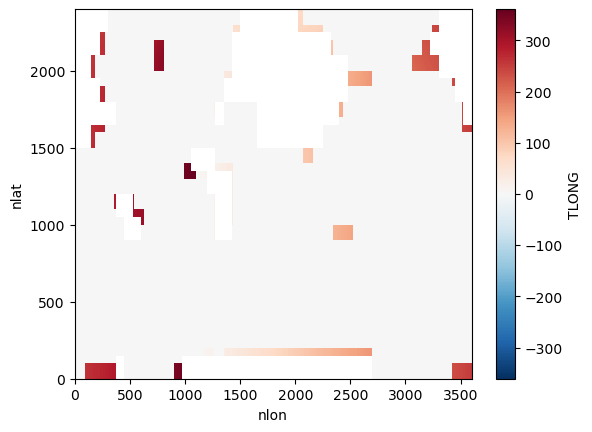

In [51]:
(ds3.TLONG - ds2.TLONG).where(~mask2).plot()

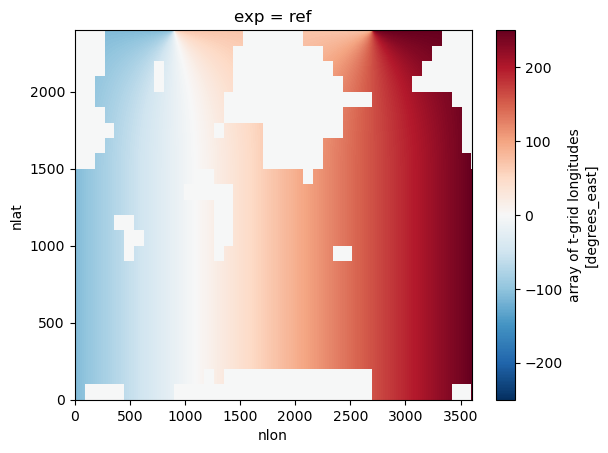

In [17]:
ds.TLONG.sel(exp='ref').plot()

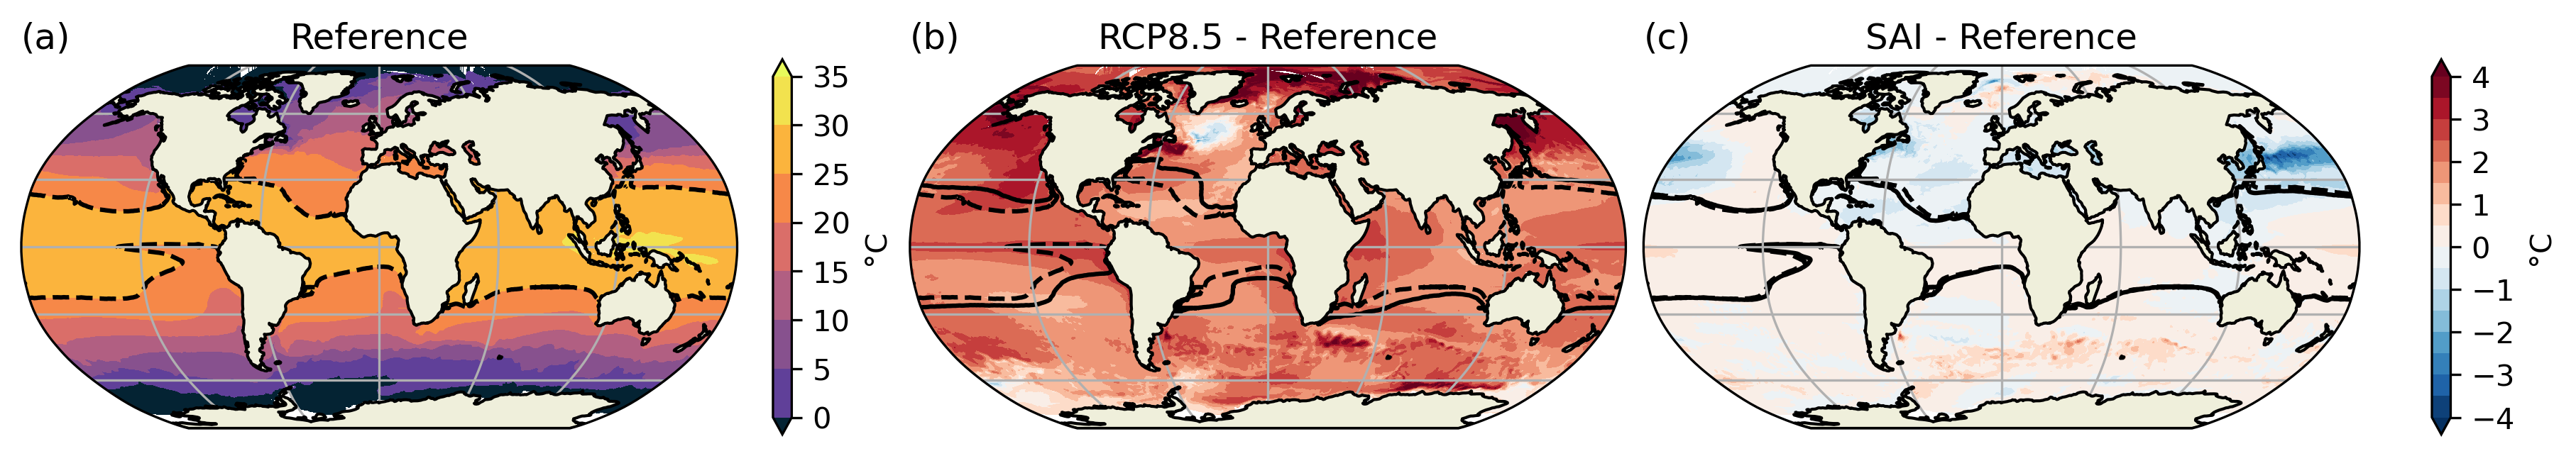

In [9]:
lons = ds.TLONG.sel(exp='ref')
lats = ds.TLAT.sel(exp='ref')
SST = ds.SST.where(~mask)
dpm = xr.DataArray([31,28,31,30,31,30,31,31,30,31,30,31], dims='time')

kwargs = dict(transform=ccrs.PlateCarree(), transform_first=True)

# for data, title in zip((SST.mean('month', keep_attrs=True), SST.sel(month=10), SST.sel(month=4)), ['annual','october','april']):
data = SST.weighted(dpm).mean('time')

fig,axs = plt.subplots(1,3, dpi=300, figsize=(12,4), layout='constrained', subplot_kw={'projection':ccrs.Robinson()})

ax=axs[0]
pcm = ax.contourf(lons, lats, data.sel(exp='ref'), levels=np.arange(0,36,5), extend='both', vmin=-10, cmap='cmo.thermal', **kwargs)
#pcm.set_rasterized(True)
ax.contour(lons, lats, data.sel(exp='ref'), levels=[25], colors='k', linestyles='--', **kwargs)
cb = fig.colorbar(pcm, ax=axs[0], shrink=0.45, orientation='vertical')
cb.ax.set_ylabel('°C')
ax.set_title('Reference')
ax.set_title('(a)', loc='left')

ax = axs[1]
ddata = data.sel(exp='cnt') - data.sel(exp='ref')
pcm = ax.contourf(lons, lats, ddata, levels=np.arange(-4,4.1,0.5), extend='both', cmap='RdBu_r', **kwargs)
#pcm.set_rasterized(True)
ax.contour(lons, lats, data.sel(exp='ref'), levels=[25], colors='k', linestyles='--', **kwargs)
ax.contour(lons, lats, data.sel(exp='cnt'), levels=[25], colors='k', linestyles='-', **kwargs)
ax.set_title('RCP8.5 - Reference')
ax.set_title('(b)', loc='left')

ax = axs[2]
ddata = data.sel(exp='sai') - data.sel(exp='ref')
pcm = ax.contourf(lons, lats, ddata, levels=np.arange(-4,4.1,0.5), extend='both', cmap='RdBu_r', **kwargs)
#pcm.set_rasterized(True)
ax.contour(lons, lats, data.sel(exp='ref'), levels=[25], colors='k', linestyles='--', **kwargs)
ax.contour(lons, lats, data.sel(exp='sai'), levels=[25], colors='k', linestyles='-', **kwargs)
ax.set_title('SAI - Reference')
ax.set_title('(c)', loc='left')

cb = fig.colorbar(pcm, ax=axs[1:], shrink=0.45, orientation='vertical')
cb.ax.set_ylabel('°C')

for ax in axs.flatten():
    ax.gridlines()
    ax.add_feature(cfeature.LAND, zorder=2, edgecolor='black')

#fig.savefig('../figures/SST.pdf', bbox_inches='tight', transparent=True)
# fig.suptitle(title)

Text(0.5, 0.98, 'JJASO')

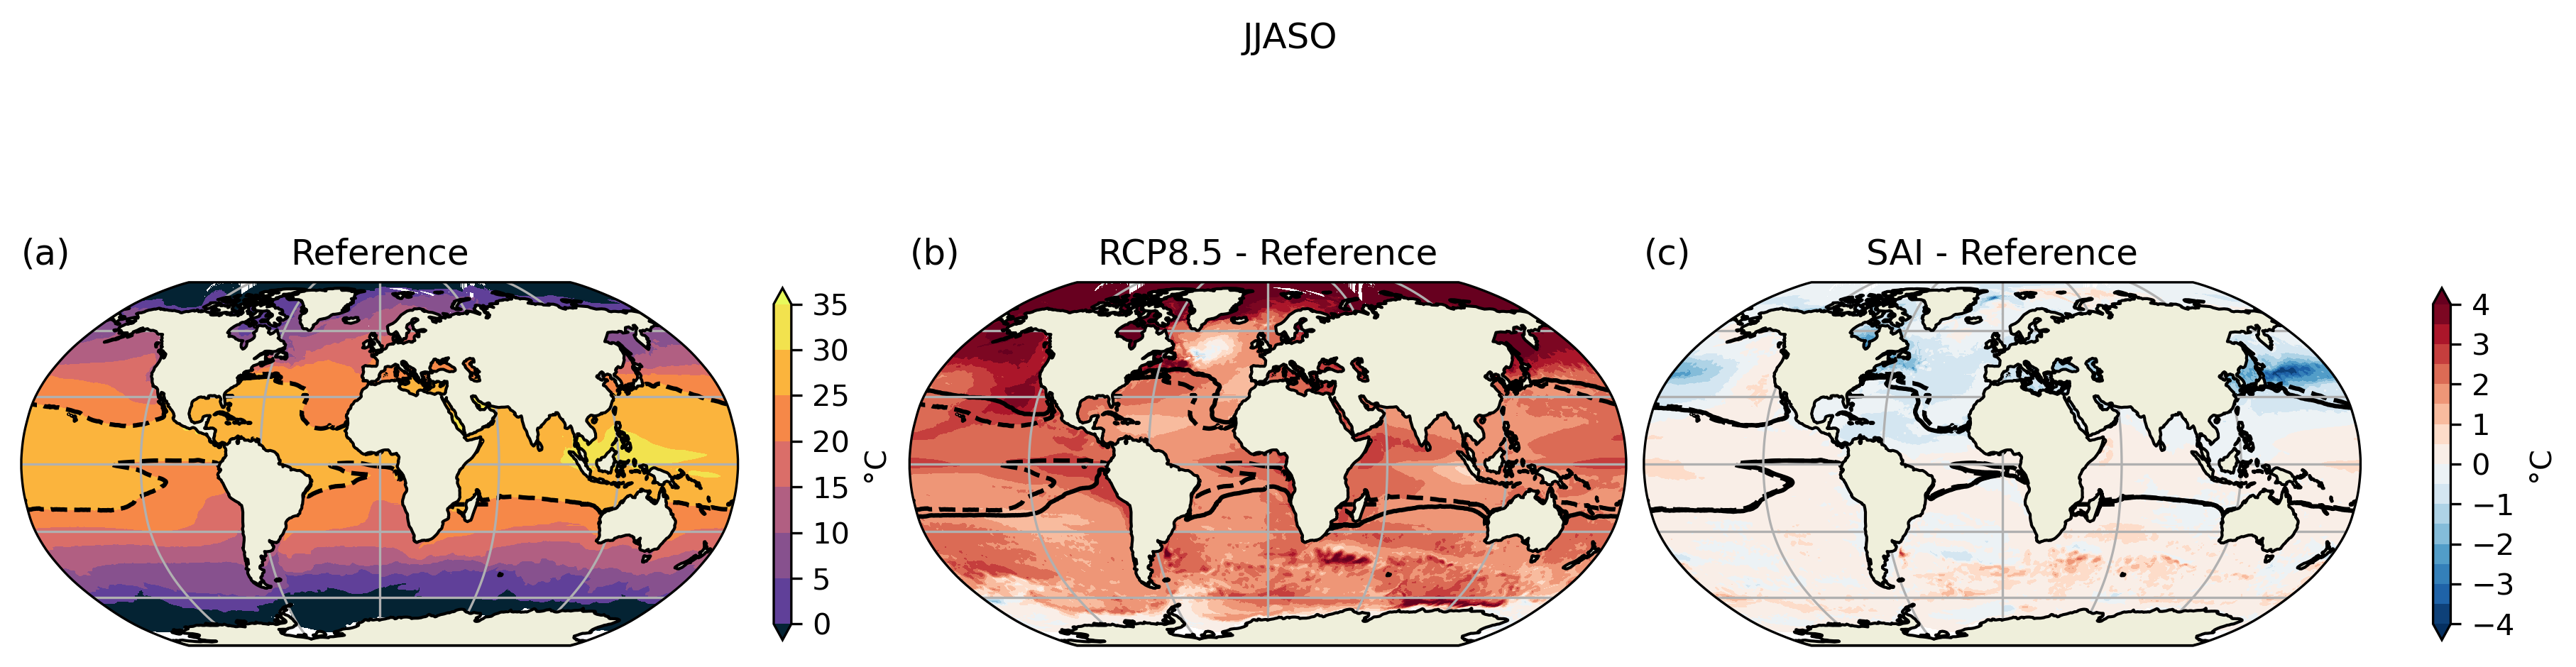

In [11]:
lons = ds.TLONG.sel(exp='ref')
lats = ds.TLAT.sel(exp='ref')
SST = ds.SST.where(~mask)
dpm = xr.DataArray([31,28,31,30,31,30,31,31,30,31,30,31], dims='time')

kwargs = dict(transform=ccrs.PlateCarree(), transform_first=True)

# for data, title in zip((SST.mean('month', keep_attrs=True), SST.sel(month=10), SST.sel(month=4)), ['annual','october','april']):
data = SST.sel(time=[6,7,8,9,10]).weighted(dpm.sel(time=[6,7,8,9,10])).mean('time')

fig,axs = plt.subplots(1,3, dpi=300, figsize=(12,4), layout='constrained', subplot_kw={'projection':ccrs.Robinson()})

ax=axs[0]
pcm = ax.contourf(lons, lats, data.sel(exp='ref'), levels=np.arange(0,36,5), extend='both', vmin=-10, cmap='cmo.thermal', **kwargs)
#pcm.set_rasterized(True)
ax.contour(lons, lats, data.sel(exp='ref'), levels=[25], colors='k', linestyles='--', **kwargs)
cb = fig.colorbar(pcm, ax=axs[0], shrink=0.45, orientation='vertical')
cb.ax.set_ylabel('°C')
ax.set_title('Reference')
ax.set_title('(a)', loc='left')

ax = axs[1]
ddata = data.sel(exp='cnt') - data.sel(exp='ref')
pcm = ax.contourf(lons, lats, ddata, levels=np.arange(-4,4.1,0.5), extend='both', cmap='RdBu_r', **kwargs)
#pcm.set_rasterized(True)
ax.contour(lons, lats, data.sel(exp='ref'), levels=[25], colors='k', linestyles='--', **kwargs)
ax.contour(lons, lats, data.sel(exp='cnt'), levels=[25], colors='k', linestyles='-', **kwargs)
ax.set_title('RCP8.5 - Reference')
ax.set_title('(b)', loc='left')

ax = axs[2]
ddata = data.sel(exp='sai') - data.sel(exp='ref')
pcm = ax.contourf(lons, lats, ddata, levels=np.arange(-4,4.1,0.5), extend='both', cmap='RdBu_r', **kwargs)
#pcm.set_rasterized(True)
ax.contour(lons, lats, data.sel(exp='ref'), levels=[25], colors='k', linestyles='--', **kwargs)
ax.contour(lons, lats, data.sel(exp='sai'), levels=[25], colors='k', linestyles='-', **kwargs)
ax.set_title('SAI - Reference')
ax.set_title('(c)', loc='left')

cb = fig.colorbar(pcm, ax=axs[1:], shrink=0.45, orientation='vertical')
cb.ax.set_ylabel('°C')

for ax in axs.flatten():
    ax.gridlines()
    ax.add_feature(cfeature.LAND, zorder=2, edgecolor='black')

#fig.savefig('../figures/SST.pdf', bbox_inches='tight', transparent=True)
fig.suptitle('JJASO')

In [14]:
# read data
dsets = [xr.open_dataset(f'../data/SST.annsum25.{exp}.1-6.nc')
         .assign_coords(exp=exp) for exp in ['ref','cnt','sai']]
for dset in dsets:
    dset['time'] = dset.time.dt.month
ds = xr.concat(dsets, dim='exp')

# add cyclical point
ds = xr.concat((ds, ds.isel(nlon=0)), dim='nlon') 

# invalid points
#mask = (ds.ULONG==-1) & (ds.ULAT==-1)
mask = (ds.TLONG==-1) & (ds.TLAT==-1)

# remove sudden 360 deg jumps in longitude
#ds.ULONG.data += 360 * ((ds.ULONG<0) & (ds.nlon>2500) & ~mask)
ds.TLONG.data -= 360 * ((ds.TLONG>250) & (ds.nlon<1100) & ~mask)
#assert (abs(ds.ULONG.diff('nlon')) > 359).sum() == 0, "sudden jumps found in longitude"
assert (abs(ds.TLONG.diff('nlon')) > 359).sum() == 0, "sudden jumps found in longitude"

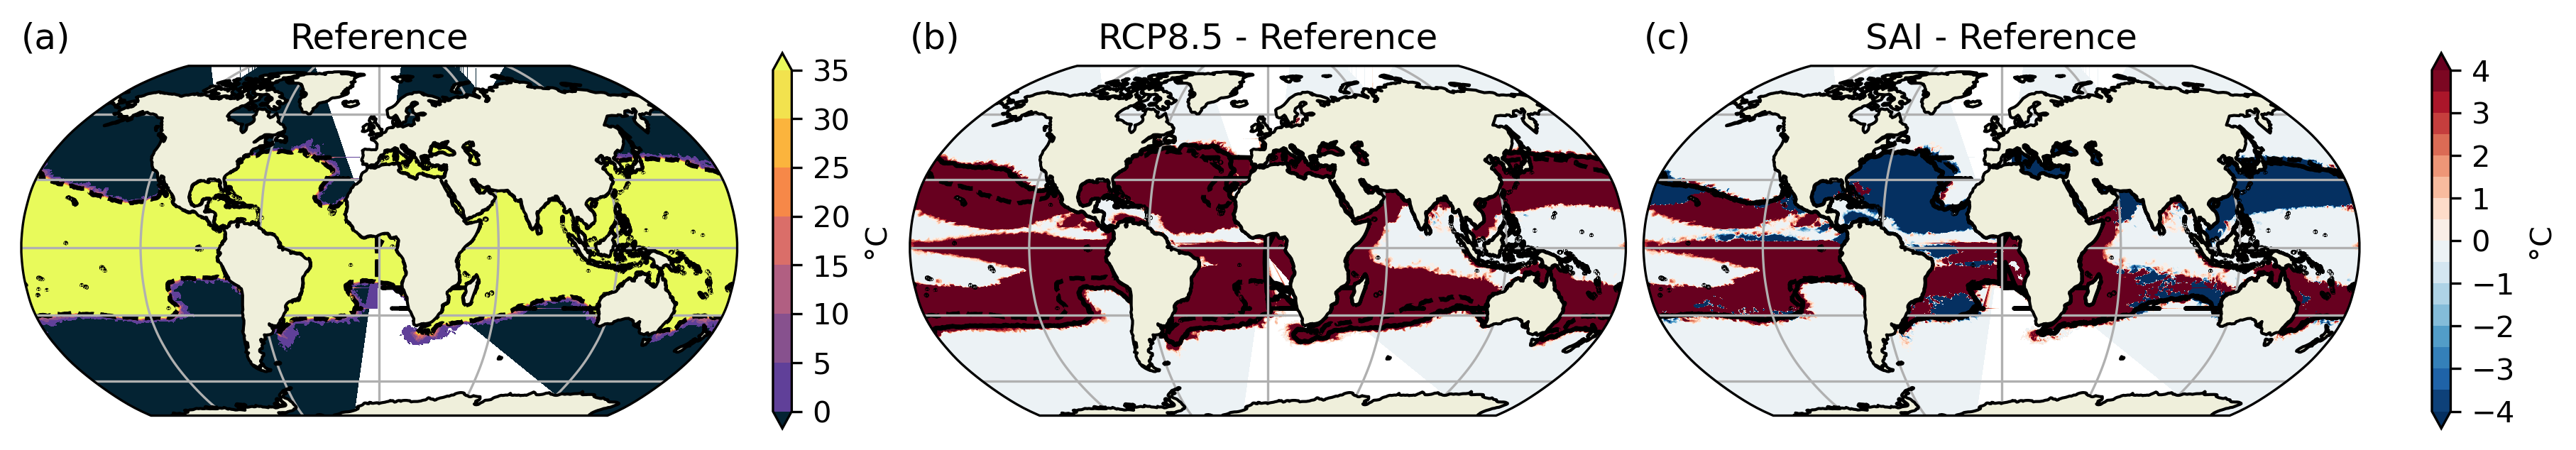

In [16]:
lons = ds.TLONG.sel(exp='ref')
lats = ds.TLAT.sel(exp='ref')
SST = ds.SST.where(~mask)
dpm = xr.DataArray([31,28,31,30,31,30,31,31,30,31,30,31], dims='time')

kwargs = dict(transform=ccrs.PlateCarree(), transform_first=True)

# for data, title in zip((SST.mean('month', keep_attrs=True), SST.sel(month=10), SST.sel(month=4)), ['annual','october','april']):
data = SST.sum('time')

fig,axs = plt.subplots(1,3, dpi=300, figsize=(12,4), layout='constrained', subplot_kw={'projection':ccrs.Robinson()})

ax=axs[0]
pcm = ax.contourf(lons, lats, data.sel(exp='ref'), levels=np.arange(0,36,5), extend='both', vmin=-10, cmap='cmo.thermal', **kwargs)
#pcm.set_rasterized(True)
ax.contour(lons, lats, data.sel(exp='ref'), levels=[25], colors='k', linestyles='--', **kwargs)
cb = fig.colorbar(pcm, ax=axs[0], shrink=0.45, orientation='vertical')
cb.ax.set_ylabel('°C')
ax.set_title('Reference')
ax.set_title('(a)', loc='left')

ax = axs[1]
ddata = data.sel(exp='cnt') - data.sel(exp='ref')
pcm = ax.contourf(lons, lats, ddata, levels=np.arange(-4,4.1,0.5), extend='both', cmap='RdBu_r', **kwargs)
#pcm.set_rasterized(True)
ax.contour(lons, lats, data.sel(exp='ref'), levels=[25], colors='k', linestyles='--', **kwargs)
ax.contour(lons, lats, data.sel(exp='cnt'), levels=[25], colors='k', linestyles='-', **kwargs)
ax.set_title('RCP8.5 - Reference')
ax.set_title('(b)', loc='left')

ax = axs[2]
ddata = data.sel(exp='sai') - data.sel(exp='ref')
pcm = ax.contourf(lons, lats, ddata, levels=np.arange(-4,4.1,0.5), extend='both', cmap='RdBu_r', **kwargs)
#pcm.set_rasterized(True)
ax.contour(lons, lats, data.sel(exp='ref'), levels=[25], colors='k', linestyles='--', **kwargs)
ax.contour(lons, lats, data.sel(exp='sai'), levels=[25], colors='k', linestyles='-', **kwargs)
ax.set_title('SAI - Reference')
ax.set_title('(c)', loc='left')

cb = fig.colorbar(pcm, ax=axs[1:], shrink=0.45, orientation='vertical')
cb.ax.set_ylabel('°C')

for ax in axs.flatten():
    ax.gridlines()
    ax.add_feature(cfeature.LAND, zorder=2, edgecolor='black')

#fig.savefig('../figures/SST.pdf', bbox_inches='tight', transparent=True)
# fig.suptitle(title)

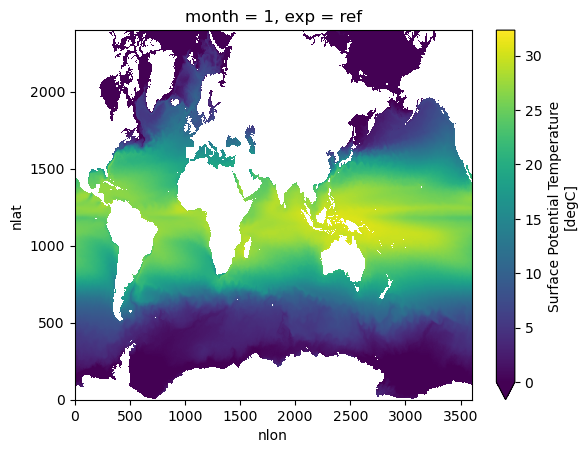

In [6]:
mask = (ds.TLONG==-1) & (ds.TLAT==-1)
ds.SST.where(~mask).sel(exp='ref', month=1).plot(vmin=0)

In [3]:
# center time (CESM time stamps are at the end of the interval, so the date is wrong)
for exp in ds:
    ds[exp]['time'] = ds[exp].time - (ds[exp].time.values[1] - ds[exp].time.values[0])/2
    tslice = slice('2003','2007') if 'ref' in exp else slice('2093','2097')
    ds[exp] = ds[exp].sel(time=tslice)
    print(f"{exp}: {ds[exp].time.min().item()} - {ds[exp].time.max().item()} steps={ds[exp].time.size}")

hres.ref.1: 2003-01-01 12:00:00 - 2007-12-31 12:00:00 steps=1825
hres.ref.2: 2003-01-01 12:00:00 - 2007-12-31 12:00:00 steps=1825
hres.ref.3: 2003-01-01 12:00:00 - 2007-12-31 12:00:00 steps=1825
hres.ref.4: 2003-01-01 12:00:00 - 2007-12-31 12:00:00 steps=1825
hres.ref.5: 2003-01-01 12:00:00 - 2007-12-31 12:00:00 steps=1825
hres.ref.6: 2003-01-01 12:00:00 - 2007-12-31 12:00:00 steps=1825
hres.cnt.1: 2093-01-01 12:00:00 - 2097-12-31 12:00:00 steps=1825
hres.cnt.2: 2093-01-01 12:00:00 - 2097-12-31 12:00:00 steps=1825
hres.cnt.3: 2093-01-01 12:00:00 - 2097-12-31 12:00:00 steps=1825
hres.cnt.4: 2093-01-01 12:00:00 - 2097-12-31 12:00:00 steps=1825
hres.cnt.5: 2093-01-01 12:00:00 - 2097-12-31 12:00:00 steps=1825
hres.cnt.6: 2093-01-01 12:00:00 - 2097-12-31 12:00:00 steps=1825
hres.sai.1: 2093-01-01 12:00:00 - 2097-12-31 12:00:00 steps=1825
hres.sai.2: 2093-01-01 12:00:00 - 2097-12-31 12:00:00 steps=1825
hres.sai.3: 2093-01-01 12:00:00 - 2097-12-31 12:00:00 steps=1825
hres.sai.4: 2093-01-01 12

In [4]:
# assign coordinates for concatenation
for tag in ds:
    _,exp,ens = tag.split('.')
    ds[tag] = ds[tag].assign_coords(exp=exp, ens=int(ens))

In [5]:
def seasonal_mean(da, months):
    da_season = (
        da.where(da.time.dt.month.isin(months), drop=True)
        .resample(time='1YS').mean()
        .assign_coords(season=''.join([' JFMAMJJASOND'[i] for i in months]))
    ) 
    return da_season

seasons = [
    [6,7,8,9,10,11,12,1], # June - January
    [10,11,12,1,2,3,4,5], # October - May
    [1,2,3,4,5,6,7,8,9,10,11,12], # annual
]

xr.concat([seasonal_mean(ds['hres.ref.1'].SST, m) for m in seasons], dim='season')

<xarray.DataArray 'SST' (season: 3, time: 5, nlat: 2400, nlon: 3600)> Size: 518MB
dask.array<concatenate, shape=(3, 5, 2400, 3600), dtype=float32, chunksize=(1, 1, 2400, 3600), chunktype=numpy.ndarray>
Coordinates:
    ULONG    (nlat, nlon) float64 69MB ...
    ULAT     (nlat, nlon) float64 69MB ...
    TLONG    (nlat, nlon) float64 69MB ...
    TLAT     (nlat, nlon) float64 69MB ...
    exp      <U3 12B 'ref'
    ens      int64 8B 1
  * time     (time) object 40B 2003-01-01 00:00:00 ... 2007-01-01 00:00:00
  * season   (season) <U12 144B 'JJASONDJ' 'ONDJFMAM' 'JFMAMJJASOND'
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Surface Potential Temperature
    units:         degC
    grid_loc:      2110
    cell_methods:  time: mean

In [6]:
# average daily data to seasonal and save results
for tag in ds:
    os.makedirs(f'./temp/{tag}/', exist_ok=True)
    fname = f'./temp/{tag}/seasonalmean.nc'
    if os.path.exists(fname):
        print(fname, 'already exists')
        continue
    fname_i = f'./temp/{tag}/.seasonalmean.nc'
    print(fname)
    dsi = xr.concat([seasonal_mean(ds['hres.ref.1'].SST, m) for m in seasons], dim='season')
    dsi.to_netcdf(fname_i, compute=True)
    os.rename(fname_i, fname)

./temp/hres.ref.1/seasonalmean.nc already exists
./temp/hres.ref.2/seasonalmean.nc already exists
./temp/hres.ref.3/seasonalmean.nc already exists
./temp/hres.ref.4/seasonalmean.nc already exists
./temp/hres.ref.5/seasonalmean.nc already exists
./temp/hres.ref.6/seasonalmean.nc already exists
./temp/hres.cnt.1/seasonalmean.nc already exists
./temp/hres.cnt.2/seasonalmean.nc already exists
./temp/hres.cnt.3/seasonalmean.nc already exists
./temp/hres.cnt.4/seasonalmean.nc already exists
./temp/hres.cnt.5/seasonalmean.nc already exists
./temp/hres.cnt.6/seasonalmean.nc already exists
./temp/hres.sai.1/seasonalmean.nc
[########################################] | 100% Completed | 322.71 s
./temp/hres.sai.2/seasonalmean.nc
[########################################] | 100% Completed | 322.56 s
./temp/hres.sai.3/seasonalmean.nc
[########################################] | 100% Completed | 322.43 s
./temp/hres.sai.4/seasonalmean.nc
[########################################] | 100% Completed | 3

In [7]:
def seasonal_mean_std(da, months):
    """Calculate interannual mean and std of da in specified months"""
    da_season = da.where(da.time.dt.month.isin(months), drop=True)
    da_seasonavg = da_season.resample(time='1YS').mean()
    mean = da_seasonavg.mean('time', keep_attrs=True).assign_attrs({
        'description': f'average over season'
    })
    std = da_seasonavg.std('time', ddof=1).assign_attrs({
        'long_name': f'interannual standard deviation of {da.name} averaged over season',
        'description': f'sample size (N): 30, ddof: N-1'
    })
    return xr.Dataset({da.name: mean, da.name+'std': std}).assign_coords({
        'season': ''.join([' JFMAMJJASOND'[i] for i in months])})

seasons = [
    [6,7,8,9,10,11,12,1], # June - January
    [10,11,12,1,2,3,4,5], # October - May
    [1,2,3,4,5,6,7,8,9,10,11,12], # annual
]


dsi = xr.concat([
    seasonal_mean_std(ds['hres.ref.2'].SST, months=season) for season in seasons
], dim='season')
dsi

<xarray.Dataset> Size: 484MB
Dimensions:  (season: 3, nlat: 2400, nlon: 3600)
Coordinates:
    ULONG    (nlat, nlon) float64 69MB dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ULAT     (nlat, nlon) float64 69MB dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    TLONG    (nlat, nlon) float64 69MB dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    TLAT     (nlat, nlon) float64 69MB dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    exp      <U3 12B 'ref'
    ens      int64 8B 2
  * season   (season) <U12 144B 'JJASONDJ' 'ONDJFMAM' 'JFMAMJJASOND'
Dimensions without coordinates: nlat, nlon
Data variables:
    SST      (season, nlat, nlon) float32 104MB dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SSTstd   (season, nlat, nlon) float32 104MB dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>

In [5]:
pbar.unregister() # don't show redundant progressbars here

# concatenate ensemble members
ds_ref = xr.concat(list(ds.values())[0:6], dim='ens')
ds_cnt = xr.concat(list(ds.values())[6:12], dim='ens')
ds_sai = xr.concat(list(ds.values())[12:18], dim='ens')

pbar.register()

In [6]:
def seasonal_mean_std(da, months):
    """Calculate interannual mean and std of da in specified months"""
    da_season = da.where(da.time.dt.month.isin(months), drop=True)
    da_seasonavg = da_season.resample(time='1YS').mean().stack(x=('ens','time'))
    mean = da_seasonavg.mean('x', keep_attrs=True).assign_attrs({
        'description': f'average over season'
    })
    std = da_seasonavg.std('x', ddof=1).assign_attrs({
        'long_name': f'interannual standard deviation of {da.name} averaged over season',
        'description': f'sample size (N): 30, ddof: N-1'
    })
    return xr.Dataset({da.name: mean, da.name+'std': std}).assign_coords({
        'season': ''.join([' JFMAMJJASOND'[i] for i in months])})

seasons = [
    [6,7,8,9,10,11,12,1], # June - January
    [10,11,12,1,2,3,4,5], # October - May
    [1,2,3,4,5,6,7,8,9,10,11,12], # annual
]

ds_season = xr.concat([
    xr.concat([
        seasonal_mean_std(dsi.SST, months) for months in seasons
    ], dim='season') for dsi in [ds_ref, ds_cnt, ds_sai]
], dim='exp')

ds_season

<xarray.Dataset> Size: 622MB
Dimensions:  (exp: 3, season: 3, nlat: 2400, nlon: 3600)
Coordinates:
  * exp      (exp) <U3 36B 'ref' 'cnt' 'sai'
  * season   (season) <U12 144B 'JJASONDJ' 'ONDJFMAM' 'JFMAMJJASOND'
Dimensions without coordinates: nlat, nlon
Data variables:
    SST      (exp, season, nlat, nlon) float32 311MB dask.array<chunksize=(1, 1, 2400, 3600), meta=np.ndarray>
    SSTstd   (exp, season, nlat, nlon) float32 311MB dask.array<chunksize=(1, 1, 2400, 3600), meta=np.ndarray>

In [7]:
client = Client(n_workers=4)
client

<Client: 'tcp://127.0.0.1:45197' processes=4 threads=128, memory=224.00 GiB>

In [8]:
ds_season = ds_season.persist()

/home/jasperdj/miniconda3/envs/geo/lib/python3.12/site-packages/distributed/client.py:3383: UserWarning: Sending large graph of size 62.49 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [19]:
months=[1,2,3]
da = ds['hres.ref.1'].assign_coords(ens=1).SST
da_season = da.where(da.time.dt.month.isin(months), drop=True)
da_seasonavg = da_season.resample(time='1YS').mean()
da_seasonavg.compute()

[########################################] | 100% Completed | 38.49 s


<xarray.DataArray 'SST' (time: 5, nlat: 2400, nlon: 3600)> Size: 173MB
array([[[nan, nan, nan, ..., -1., -1., -1.],
        [nan, nan, nan, ..., -1., -1., -1.],
        [nan, nan, nan, ..., -1., -1., -1.],
        ...,
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.]],

       [[nan, nan, nan, ..., -1., -1., -1.],
        [nan, nan, nan, ..., -1., -1., -1.],
        [nan, nan, nan, ..., -1., -1., -1.],
        ...,
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.]],

       [[nan, nan, nan, ..., -1., -1., -1.],
        [nan, nan, nan, ..., -1., -1., -1.],
        [nan, nan, nan, ..., -1., -1., -1.],
        ...,
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.]],

       [[nan, nan, nan, ..., -1., -1., -1.],
        [nan, nan, nan, ..., -1., -1., -1.],
        [nan, nan, nan, ..., -1., -1., -1.],
        ...,
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.]],

       [[nan, nan, nan, ..., -1., -1., -1.],
        [nan, nan, nan, ..., -1., -1., -1.],
        [nan, nan, nan, ..., -1., -1., -1.],
        ...,
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.]]], dtype=float32)
Coordinates:
    ULONG    (nlat, nlon) float64 69MB dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ULAT     (nlat, nlon) float64 69MB dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    TLONG    (nlat, nlon) float64 69MB dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    TLAT     (nlat, nlon) float64 69MB dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    exp      <U3 12B 'ref'
    ens      int64 8B 1
  * time     (time) object 40B 2003-01-01 00:00:00 ... 2007-01-01 00:00:00
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Surface Potential Temperature
    units:         degC
    grid_loc:      2110
    cell_methods:  time: mean

In [7]:
# old function to obtain monthly mean and std
def monthly_mean_std(da):
    """Compute monthly mean and interannual standard deviation of monthly means"""
    mon_mean = da.resample(time='1MS').mean() # monthly mean
    gb = mon_mean.stack(x=('ens','time')).groupby('time.month')
    mean = gb.mean()
    std = gb.std(ddof=1).assign_attrs(
        {'long_name':f'interannual standard deviation of {da.name}',
         'description':'sample size (N): 30, degrees of freedom: N-1'})
    return xr.Dataset({da.name: mean, da.name+'std': std})

# dsm = xr.concat([
#     monthly_mean_std(dsi.SST) for dsi in (ds_ref, ds_cnt, ds_sai)
# ], dim='exp')

# dsm['tw'] = ds_ref.sel(time='2003').time.groupby('time.month').count().drop_vars('exp')
# dsm

In [8]:
def count_warm_days(SST, thresh=25):
    """return number of days per year on which SST >= 25C (and its std)"""
    counts = (SST >= thresh).groupby('time.year').sum().stack(x=('ens','year'))
    mean = counts.mean('x').assign_attrs({'long_name':'number of days with SST >= 25 degC'})
    std = counts.std('x', ddof=1).assign_attrs({'long_name': 'interannual std of SST25'})
    return xr.Dataset({f'SST{thresh}': mean, f'SST{thresh}std': std})

ds_count = xr.concat([count_warm_days(dsi.SST) for dsi in [ds_ref, ds_cnt, ds_sai]], dim='exp')
ds_count

<xarray.Dataset> Size: 415MB
Dimensions:   (exp: 3, nlat: 2400, nlon: 3600)
Coordinates:
  * exp       (exp) <U3 36B 'ref' 'cnt' 'sai'
Dimensions without coordinates: nlat, nlon
Data variables:
    SST25     (exp, nlat, nlon) float64 207MB dask.array<chunksize=(1, 24, 3600), meta=np.ndarray>
    SST25std  (exp, nlat, nlon) float64 207MB dask.array<chunksize=(1, 24, 3600), meta=np.ndarray>

In [9]:
dsm = xr.merge((ds_season, ds_count))
dsm

<xarray.Dataset> Size: 1GB
Dimensions:   (exp: 3, season: 3, nlat: 2400, nlon: 3600)
Coordinates:
  * exp       (exp) <U3 36B 'ref' 'cnt' 'sai'
  * season    (season) <U12 144B 'JJASONDJ' 'ONDJFMAM' 'JFMAMJJASOND'
Dimensions without coordinates: nlat, nlon
Data variables:
    SST       (exp, season, nlat, nlon) float32 311MB dask.array<chunksize=(1, 1, 24, 3600), meta=np.ndarray>
    SSTstd    (exp, season, nlat, nlon) float32 311MB dask.array<chunksize=(1, 1, 24, 3600), meta=np.ndarray>
    SST25     (exp, nlat, nlon) float64 207MB dask.array<chunksize=(1, 24, 3600), meta=np.ndarray>
    SST25std  (exp, nlat, nlon) float64 207MB dask.array<chunksize=(1, 24, 3600), meta=np.ndarray>

In [ ]:
dsm = dsm.compute()

In [10]:
cluster = LocalCluster(silence_logs=60, interface='ib0')
client = Client(cluster)

In [11]:
SST_tmean = []
for exp in ds:
    gb = ds[exp].SST.groupby('time.month')
    SST_tmean.append(gb.mean('time', keep_attrs=True).persist())

progress(SST_tmean[:], multi=False)

In [7]:
SSTref = xr.concat(SST_tmean[0:6], dim='ens', compat='override', join='exact', coords='minimal')
SSTcnt = xr.concat(SST_tmean[6:12], dim='ens', compat='override', join='exact', coords='minimal')
SSTsai = xr.concat(SST_tmean[12:18], dim='ens', compat='override', join='exact', coords='minimal')

SSTref = SSTref.mean('ens', keep_attrs=True)
SSTcnt = SSTcnt.mean('ens', keep_attrs=True)
SSTsai = SSTsai.mean('ens', keep_attrs=True)

SST = xr.concat([SSTref, SSTcnt, SSTsai], dim='exp', compat='override', join='exact', coords='minimal')
SST = SST.assign_coords({'exp':('exp',['ref','cnt','sai'])})
SST = SST.persist()

progress(SST, multi=False)

/home/jasperdj/miniconda3/envs/geo/lib/python3.12/site-packages/distributed/client.py:3383: UserWarning: Sending large graph of size 10.80 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [13]:
SST = SST.compute()

In [14]:
%%time
SST.to_netcdf("../data/SST.nc")

CPU times: user 77.9 ms, sys: 221 ms, total: 299 ms
Wall time: 326 ms


In [4]:
exp = 'hres.ref.1'
warm_days = (ds[exp].SST>25).groupby('time.year').sum()

In [25]:
# add cyclical point
warm_days = xr.concat((warm_days, warm_days.isel(nlon=0)), dim='nlon') 

# invalid points
mask = (warm_days.ULONG==-1) & (warm_days.ULAT==-1)

# remove sudden 360 deg jumps in longitude
warm_days.ULONG.data += 360 * ((warm_days.ULONG<0) & (warm_days.nlon>2500) & ~mask)
assert (abs(warm_days.ULONG.diff('nlon')) > 359).sum() == 0, "sudden jumps found in longitude"

[########################################] | 100% Completed | 302.61 ms


In [32]:
warm_days = warm_days.persist()
progress(warm_days, multi=False)

In [5]:
%%time
warm_days = warm_days.compute()

[########################################] | 100% Completed | 100.33 s
CPU times: user 11min 52s, sys: 5min 45s, total: 17min 38s
Wall time: 1min 40s


[########################################] | 100% Completed | 302.12 ms
[########################################] | 100% Completed | 201.80 ms


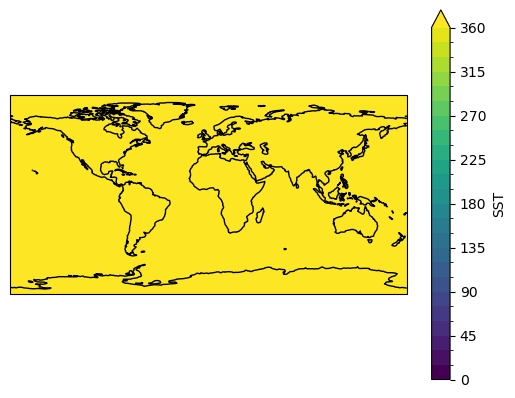

In [22]:
ax = plt.axes(projection=ccrs.PlateCarree())
warm_days.mean('year').plot.contourf(ax=ax, x='TLONG', y='TLAT', levels=range(0,366,15), transform=ccrs.PlateCarree())
ax.coastlines()

## Plotting

In [4]:
ds =  xr.open_dataset("../data/SST.nc")

# add cyclical point
ds = xr.concat((ds, ds.isel(nlon=0)), dim='nlon') 

# invalid points
mask = (ds.ULONG==-1) & (ds.ULAT==-1)

# remove sudden 360 deg jumps in longitude
ds.ULONG.data += 360 * ((ds.ULONG<0) & (ds.nlon>2500) & ~mask)
assert (abs(ds.ULONG.diff('nlon')) > 359).sum() == 0, "sudden jumps found in longitude"

/scratch-local/jasperdj.18050923/ipykernel_3855170/3205705533.py:14: UserWarning: Rasterization of '<cartopy.mpl.contour.GeoContourSet object at 0x14f6ec345400>' will be ignored
  pcm.set_rasterized(True)
/scratch-local/jasperdj.18050923/ipykernel_3855170/3205705533.py:23: UserWarning: Rasterization of '<cartopy.mpl.contour.GeoContourSet object at 0x14f6ec3dd4c0>' will be ignored
  pcm.set_rasterized(True)
/scratch-local/jasperdj.18050923/ipykernel_3855170/3205705533.py:31: UserWarning: Rasterization of '<cartopy.mpl.contour.GeoContourSet object at 0x14f6ec8f84a0>' will be ignored
  pcm.set_rasterized(True)


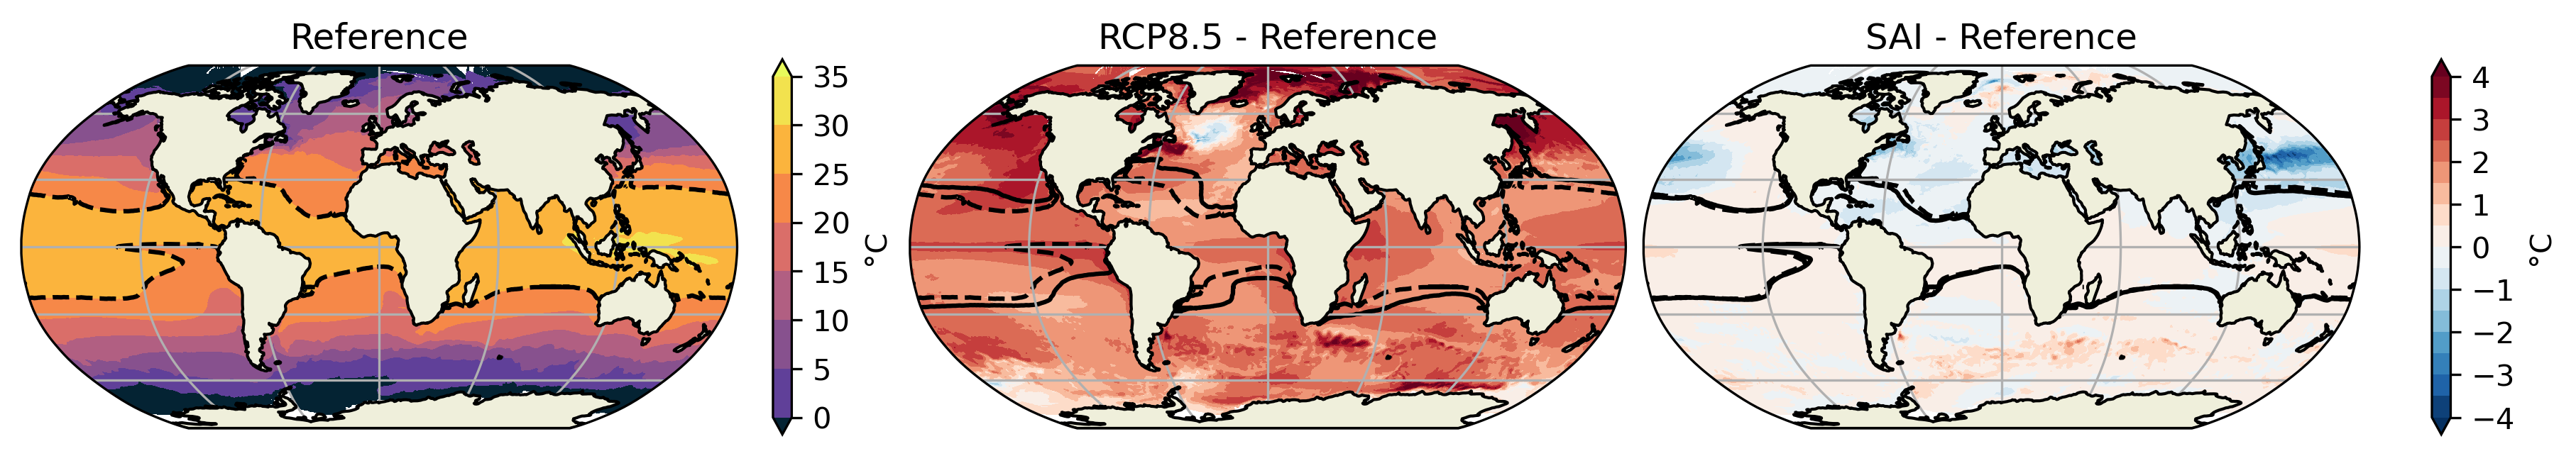

In [5]:
lons = ds.ULONG
lats = ds.ULAT
SST = ds.SST.where(~mask)

kwargs = dict(transform=ccrs.PlateCarree(), transform_first=True)

# for data, title in zip((SST.mean('month', keep_attrs=True), SST.sel(month=10), SST.sel(month=4)), ['annual','october','april']):
data = SST.mean('month')

fig,axs = plt.subplots(1,3, dpi=300, figsize=(12,4), layout='constrained', subplot_kw={'projection':ccrs.Robinson()})

ax=axs[0]
pcm = ax.contourf(lons, lats, data.sel(exp='ref'), levels=np.arange(0,36,5), extend='both', vmin=-10, cmap='cmo.thermal', **kwargs)
pcm.set_rasterized(True)
ax.contour(lons, lats, data.sel(exp='ref'), levels=[25], colors='k', linestyles='--', **kwargs)
cb = fig.colorbar(pcm, ax=axs[0], shrink=0.45, orientation='vertical')
cb.ax.set_ylabel('°C')
ax.set_title('Reference')

ax = axs[1]
ddata = data.sel(exp='cnt') - data.sel(exp='ref')
pcm = ax.contourf(lons, lats, ddata, levels=np.arange(-4,4.1,0.5), extend='both', cmap='RdBu_r', **kwargs)
pcm.set_rasterized(True)
ax.contour(lons, lats, data.sel(exp='ref'), levels=[25], colors='k', linestyles='--', **kwargs)
ax.contour(lons, lats, data.sel(exp='cnt'), levels=[25], colors='k', linestyles='-', **kwargs)
ax.set_title('RCP8.5 - Reference')

ax = axs[2]
ddata = data.sel(exp='sai') - data.sel(exp='ref')
pcm = ax.contourf(lons, lats, ddata, levels=np.arange(-4,4.1,0.5), extend='both', cmap='RdBu_r', **kwargs)
pcm.set_rasterized(True)
ax.contour(lons, lats, data.sel(exp='ref'), levels=[25], colors='k', linestyles='--', **kwargs)
ax.contour(lons, lats, data.sel(exp='sai'), levels=[25], colors='k', linestyles='-', **kwargs)
ax.set_title('SAI - Reference')

cb = fig.colorbar(pcm, ax=axs[1:], shrink=0.45, orientation='vertical')
cb.ax.set_ylabel('°C')

for ax in axs.flatten():
    ax.gridlines()
    ax.add_feature(cfeature.LAND, zorder=2, edgecolor='black')

#fig.savefig('../figures/SST.pdf', bbox_inches='tight', transparent=True)
# fig.suptitle(title)

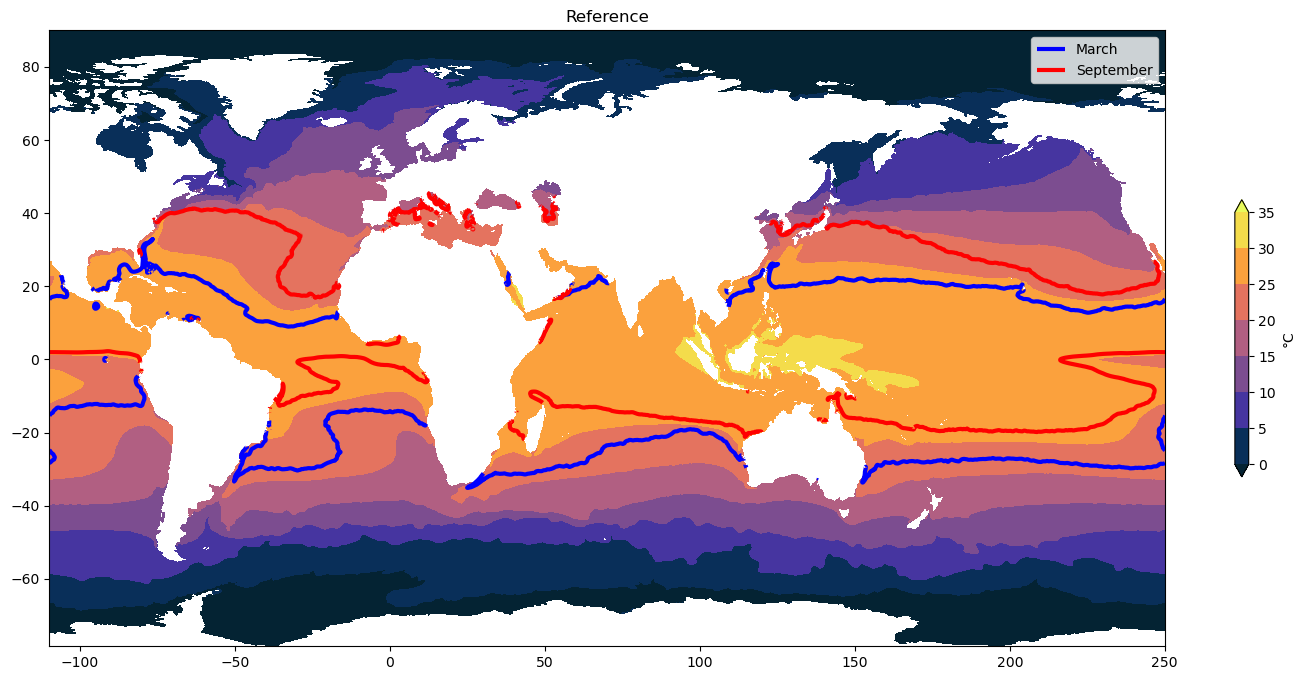

In [25]:
lons = ds.ULONG
lats = ds.ULAT
SST = ds.SST.where(~mask)
data = SST.mean('month')
kwargs = {}

fig = plt.figure(figsize=(18,8))
ax=plt.axes(projection=None)
pcm = ax.contourf(lons, lats, data.sel(exp='ref'), levels=range(0,36,5), extend='both', cmap='cmo.thermal', **kwargs)
for mon in SST.month:
    data = SST.sel(month=mon, exp='ref')
    ax.contour(lons, lats, data, levels=[25], alpha=mon.item()/12, colors='k', linestyles='-', **kwargs)
cs1= ax.contour(lons, lats, SST.sel(month=3, exp='ref'), levels=[25], colors='b', linewidths=3, **kwargs)
cs2 = ax.contour(lons, lats, SST.sel(month=9, exp='ref'), levels=[25], colors='r', linewidths=3, **kwargs)
cb = fig.colorbar(pcm, ax=ax, shrink=0.45, orientation='vertical')
cb.ax.set_ylabel('°C')
ax.set_title('Reference')
ax.legend([cs1.legend_elements()[0][0],cs2.legend_elements()[0][0]], ['March', 'September'])
#ax.gridlines()
#ax.add_feature(cfeature.LAND, zorder=2, edgecolor='black')

In [28]:
import json

with open('segments.txt','w') as f:
    allsegs_list = {str(c): [list(s) for s in segs] for c,segs in zip(cs.levels,allsegs)}
    json.dump(allsegs_list, f)

with open('segments.txt','r') as f:
    allsegs_read = json.load(f)

-rw-r----- 1 jasperdj jasperdj 674K Apr 15 16:47 ../figures/SST.pdf
